# This notebook contains experiments with CTMLE related methods

In [1]:
import numpy as np
import pandas as pd
import contextlib
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import io

import os
import sys
from joblib import dump,load
from tqdm import tqdm


from experiment_utils import *
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)
from comparator.DOPE.estimators import *

src_path = os.path.abspath("../src")
sys.path.append(src_path)
from models import *
from utils import *


import matplotlib.pyplot as plt
import seaborn as sns

# Suppress R console output
@contextlib.contextmanager
def suppress_r_output():
    r_output = io.StringIO()
    with contextlib.redirect_stdout(r_output), contextlib.redirect_stderr(r_output):
        yield

with suppress_r_output():
    robjects.r['source'](r'../comparator/CollaborativeLearning/models.r')
    run_comparator = robjects.globalenv['run_comparator']

In [10]:
def collaborative_trial_single(n, p, df=None, ate=4,
                          cross_fit=True, n_folds=5, ps_model='original',or_model='original',w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=False, mu_est=False, stds_return=True, coverage_return=False):

    random.seed(random_seed)

    pandas2ri.activate()

    with suppress_r_output():
        r_df = pandas2ri.py2rpy(df)

    if propen_est:
        ates, stds, df_est = single_trial(
            true_ate=ate, df_full=df, p=p,
            ps_model=ps_model, or_model=or_model,
            w_model=w_model,
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds, stds_return=True,coverage_return=False
        )
        with suppress_r_output():
            r_df = pandas2ri.py2rpy(df_est)
            r_result = run_comparator(df=r_df, p=p, propen_est=propen_est, mu_est=mu_est,random_seed=random_seed)
            result = dict(zip(r_result.names, list(r_result)))
    else:
        with suppress_r_output():
            r_result = run_comparator(df=r_df, p=p, propen_est=propen_est, mu_est=mu_est,random_seed=random_seed)
            result = dict(zip(r_result.names, list(r_result)))

        df['propen'] = result['pi_hat']
        df['mu0'] = result['r0_out']
        df['mu1'] = result['r1_out']

        # Run single trial with results
        ates, stds = single_trial(
            true_ate=ate, df_full=df, p=p,
            ps_model=ps_model, or_model=or_model,
            w_model=w_model,
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds, stds_return=True,coverage_return=False
        )

    # dope
    X_cols = [f"X{i}" for i in range(1, p + 1)]
    ates_dope, vars_dope = SI_IM_cf(T=df['A'].values,Y=df['y'].values, W=df[X_cols].values)

    all_ate = {'true_ate':ate,
                'ate_tmle':result['ate.tmle'][0],
                'ate_ctmle':result['ate.ctmle'][0],
                'ate_cbps':result['ate.cbps'][0],
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw'],
                'ate_siaipw': ates_dope[1],
                'ate_sioapw': ates_dope[2],
                'ate_siobpw': ates_dope[3]
                }

    all_std = {
                'std_tmle':result['sd.tmle'][0],
                'std_ctmle':result['sd.ctmle'][0],
                'std_cbps':result['sd.cbps'][0],
                'std_mr':stds['ate_mr'],
                'std_ipw':stds['ate_ipw'],
                'std_amr':stds['ate_amr'],
                'std_aipw':stds['ate_aipw'],
                'std_siaipw':np.sqrt(vars_dope[1]),
                'std_sioapw':np.sqrt(vars_dope[2]),
                'std_siobpw': np.sqrt(vars_dope[3])
                }
    return all_ate, all_std

def collaborative_trial(num_trials = 200, n = 200, p = 400, p_instr=100, data_type='synthetic_v2', ate = 2, strength_instr= 1, strength_conf = 1, strength_outcome = 20, gamma = 10,
                          cross_fit=True, n_folds=5, ps_model='original',or_model='original',w_model='kernel_ridge_regression', random_seed=42, 
                          propen_est=False, mu_est=False, 
                          stds_return=True, coverage_return=False):
    ate_results = {'true_ate':[],
                'ate_tmle':[],
                'ate_ctmle':[],
                'ate_cbps':[],
                'ate_mr':[],
                'ate_ipw':[],
                'ate_amr':[],
                'ate_aipw':[],
                'ate_siaipw':[],
                'ate_sioapw':[],
                'ate_siobpw':[]
                }

    std_results = {
                'std_tmle':[],
                'std_ctmle':[],
                'std_cbps':[],
                'std_mr':[],
                'std_ipw':[],
                'std_amr':[],
                'std_aipw':[],
                'std_siaipw':[],
                'std_sioapw':[],
                'std_siobpw':[]
                }
    for i in tqdm(range(num_trials)):
        random.seed(random_seed+i)
        if data_type == 'synthetic_v2':
            p_confound = 5
            p_outcome = 5
            p_spurious = p - p_instr-p_confound-p_outcome
            df = generate_synthetic_data_v2(n=n, p_instr=p_instr, p_confound=p_confound, p_spurious=p_spurious, p_outcome=p_outcome, gamma_homo=10, gamma_hetero=4, 
                        beta_instr=1, beta_confound=0.5, beta_outcome=0.5, propen_model='lr', 
                        heteroscedasticity=False, outcome_type='nonlinear',  misspecified_propen=False, 
                        heterogeneous_treatment=False)
            df_mc = generate_synthetic_data_v2(n=10000, p_instr=p_instr, p_confound=p_confound, p_spurious=p_spurious, p_outcome=p_outcome, gamma_homo=10, gamma_hetero=4, 
                        beta_instr=1, beta_confound=0.5, beta_outcome=0.5, propen_model='lr', 
                        heteroscedasticity=False, outcome_type='nonlinear',  misspecified_propen=False, 
                        heterogeneous_treatment=False)
            ate = np.mean(df_mc['mu1'] - df_mc['mu0'])
        elif data_type == 'causl':
            df = generate_data_causl(n=n, nI=p_instr, nX=2, nO=2, nS=1, ate=ate, beta_cov=0, strength_instr=strength_instr, strength_conf=1, strength_outcome=1)
            ate = ate
            p = p_instr + 5
        elif data_type == 'causl_non_linear':
            df = sim_data_causl_non_linear(n=n, nI=p_instr, nX=5, nO=5, nS=5, 
                                        ate=ate, beta_cov=0, strength_instr=strength_instr, strength_conf=strength_conf, strength_outcome=20)
            p = p_instr + 15
        elif data_type == 'causal_non_linear_propen':
            df = sim_data_causl_non_linear_propen(n=n, nI=p_instr, nX=5, nO=5, nS=5, 
                                        ate=ate, beta_cov=0, strength_instr=strength_instr, strength_conf=strength_conf, strength_outcome=20)
            p = p_instr + 15
        
        single_all_ate, single_all_std = collaborative_trial_single(n=n, p=p, df=df, ate=ate,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model, or_model=or_model, w_model=w_model, random_seed=42+i,
                          propen_est = propen_est, mu_est = mu_est, stds_return=stds_return, coverage_return=coverage_return)
        
        for key, value in single_all_ate.items():
            ate_results[key].append(value)
        for key, value in single_all_std.items():
            std_results[key].append(value)
    return ate_results, std_results

# When there is large sample of data (to test the ci)


In [5]:
p_instr_values = [1,5]

for p_instr in p_instr_values:
    # Run the trial with the current p_instr value
    ate_results, std_results = collaborative_trial(
        num_trials=50, 
        n=3000, 
        p_instr=p_instr,          # Use the current value of p_instr
        ate=5, 
        data_type='causl',
        strength_instr=1, 
        strength_conf=0.5, 
        strength_outcome=20,
        cross_fit=True, 
        n_folds=5, 
        ps_model='lr', 
        or_model='lr',  
        random_seed=42, 
        propen_est=True, 
        mu_est=True, 
        stds_return=True, 
        coverage_return=False
    )

    # Create file names that include the current p_instr value
    ate_output_file = f"results/CollaborativeLearning/causl/ate_n3000_s{p_instr}.joblib"
    std_output_file = f"results/CollaborativeLearning/causl/std_n3000_s{p_instr}.joblib"

    # Ensure that the directory exists
    os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
    os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
    
    # Save the results
    dump(ate_results, ate_output_file)
    print(f"Results saved to {ate_output_file}")
    dump(std_results, std_output_file)
    print(f"Results saved to {std_output_file}")


100%|██████████| 50/50 [45:23<00:00, 54.47s/it]


Results saved to results/CollaborativeLearning/causl/ate_n3000_s1.joblib
Results saved to results/CollaborativeLearning/causl/std_n3000_s1.joblib


100%|██████████| 50/50 [44:43<00:00, 53.68s/it]

Results saved to results/CollaborativeLearning/causl/ate_n3000_s5.joblib
Results saved to results/CollaborativeLearning/causl/std_n3000_s5.joblib


# Non-linear potential outcome

In [ ]:
p_instr_values = [1, 5, 10, 15, 20]

for p_instr in p_instr_values:
    # Run the trial with the current p_instr value
    ate_results, std_results = collaborative_trial(
        num_trials=200, 
        n=800, 
        p_instr=p_instr,          # Use the current value of p_instr
        ate=5, 
        data_type='causl_non_linear',
        strength_instr=1, 
        strength_conf=0.5, 
        strength_outcome=20,
        cross_fit=True, 
        n_folds=5, 
        ps_model='lr', 
        or_model='torch_nn',  
        random_seed=42, 
        propen_est=True, 
        mu_est=True, 
        stds_return=True, 
        coverage_return=False
    )

    # Create file names that include the current p_instr value
    ate_output_file = f"results/CollaborativeLearning/causl_non_linear/ate_n800_s{p_instr}.joblib"
    std_output_file = f"results/CollaborativeLearning/causl_non_linear/std_n800_s{p_instr}.joblib"

    # Ensure that the directory exists
    os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
    os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
    
    # Save the results
    dump(ate_results, ate_output_file)
    print(f"Results saved to {ate_output_file}")
    dump(std_results, std_output_file)
    print(f"Results saved to {std_output_file}")


In [11]:
p_instr_values = [1, 5, 10, 15, 20]

for p_instr in p_instr_values:
    # Run the trial with the current p_instr value
    ate_results, std_results = collaborative_trial(
        num_trials=200, 
        n=600, 
        p_instr=p_instr,          # Use the current value of p_instr
        ate=5, 
        data_type='causl_non_linear',
        strength_instr=1, 
        strength_conf=0.5, 
        strength_outcome=20,
        cross_fit=True, 
        n_folds=5, 
        ps_model='lr', 
        or_model='torch_nn',  
        random_seed=42, 
        propen_est=True, 
        mu_est=True, 
        stds_return=True, 
        coverage_return=False
    )

    # Create file names that include the current p_instr value
    ate_output_file = f"results/CollaborativeLearning/causl_non_linear/new/ate_n600_s{p_instr}.joblib"
    std_output_file = f"results/CollaborativeLearning/causl_non_linear/new/std_n600_s{p_instr}.joblib"

    # Ensure that the directory exists
    os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
    os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

    # Save the results
    dump(ate_results, ate_output_file)
    print(f"Results saved to {ate_output_file}")
    dump(std_results, std_output_file)
    print(f"Results saved to {std_output_file}")


100%|██████████| 200/200 [30:46<00:00,  9.23s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n600_s1.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n600_s1.joblib


100%|██████████| 200/200 [38:31<00:00, 11.56s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n600_s5.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n600_s5.joblib


100%|██████████| 200/200 [44:24<00:00, 13.32s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n600_s10.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n600_s10.joblib


100%|██████████| 200/200 [52:25<00:00, 15.73s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n600_s15.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n600_s15.joblib


100%|██████████| 200/200 [1:03:47<00:00, 19.14s/it]

Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n600_s20.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n600_s20.joblib


In [12]:
p_instr_values = [1, 5, 10, 15, 20]
# p_instr_values = [20]
for p_instr in p_instr_values:
    # Run the trial with the current p_instr value
    ate_results, std_results = collaborative_trial(
        num_trials=200, 
        n=1000, 
        p_instr=p_instr,          # Use the current value of p_instr
        ate=5, 
        data_type='causl_non_linear',
        strength_instr=1, 
        strength_conf=0.5, 
        strength_outcome=20,
        cross_fit=True, 
        n_folds=5, 
        ps_model='lr', 
        or_model='torch_nn',  
        random_seed=42, 
        propen_est=True, 
        mu_est=True, 
        stds_return=True, 
        coverage_return=False
    )

    # Create file names that include the current p_instr value
    ate_output_file = f"results/CollaborativeLearning/causl_non_linear/new/ate_n1000_s{p_instr}.joblib"
    std_output_file = f"results/CollaborativeLearning/causl_non_linear/new/std_n1000_s{p_instr}.joblib"

    # Ensure that the directory exists
    os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
    os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

    # Save the results
    dump(ate_results, ate_output_file)
    print(f"Results saved to {ate_output_file}")
    dump(std_results, std_output_file)
    print(f"Results saved to {std_output_file}")


100%|██████████| 200/200 [50:22<00:00, 15.11s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n1000_s1.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n1000_s1.joblib


100%|██████████| 200/200 [56:15<00:00, 16.88s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n1000_s5.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n1000_s5.joblib


100%|██████████| 200/200 [1:01:58<00:00, 18.59s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n1000_s10.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n1000_s10.joblib


100%|██████████| 200/200 [1:12:01<00:00, 21.61s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n1000_s15.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n1000_s15.joblib


100%|██████████| 200/200 [1:27:24<00:00, 26.22s/it]

Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n1000_s20.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n1000_s20.joblib


In [13]:
p_instr_values = [1, 5, 10, 15, 20]
# p_instr_values = [20]
for p_instr in p_instr_values:
    # Run the trial with the current p_instr value
    ate_results, std_results = collaborative_trial(
        num_trials=200, 
        n=400, 
        p_instr=p_instr,          # Use the current value of p_instr
        ate=5, 
        data_type='causl_non_linear',
        strength_instr=1, 
        strength_conf=0.5, 
        strength_outcome=20,
        cross_fit=True, 
        n_folds=5, 
        ps_model='lr', 
        or_model='torch_nn',  
        random_seed=42, 
        propen_est=True, 
        mu_est=True, 
        stds_return=True, 
        coverage_return=False
    )

    # Create file names that include the current p_instr value
    ate_output_file = f"results/CollaborativeLearning/causl_non_linear/new/ate_n400_s{p_instr}.joblib"
    std_output_file = f"results/CollaborativeLearning/causl_non_linear/new/std_n400_s{p_instr}.joblib"

    # Ensure that the directory exists
    os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
    os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

    # Save the results
    dump(ate_results, ate_output_file)
    print(f"Results saved to {ate_output_file}")
    dump(std_results, std_output_file)
    print(f"Results saved to {std_output_file}")


100%|██████████| 200/200 [25:09<00:00,  7.55s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n400_s1.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n400_s1.joblib


100%|██████████| 200/200 [27:57<00:00,  8.39s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n400_s5.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n400_s5.joblib


100%|██████████| 200/200 [32:30<00:00,  9.75s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n400_s10.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n400_s10.joblib


100%|██████████| 200/200 [43:51<00:00, 13.16s/it]


Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n400_s15.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n400_s15.joblib


100%|██████████| 200/200 [54:55<00:00, 16.48s/it]

Results saved to results/CollaborativeLearning/causl_non_linear/new/ate_n400_s20.joblib
Results saved to results/CollaborativeLearning/causl_non_linear/new/std_n400_s20.joblib


In [143]:
# Compute summary statistics
ate_results = load("results/CollaborativeLearning/causl_non_linear/ate_n400_s5.joblib")
methods = [ 'ate_tmle', 'ate_ctmle', 'ate_cbps',  'ate_ipw','ate_aipw',  'ate_mr','ate_amr','ate_siaipw', 'ate_sioapw', 'ate_siobpw']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
    }
summary_stats = []
for method in methods:
    estimates = np.array(ate_results[method])
    mean_diff = np.mean(estimates - true_ate)
    mean_abs_diff = np.mean(np.abs(estimates - true_ate))
    rmse = np.sqrt(np.mean((estimates - true_ate)**2))
    summary_stats.append({'Method': method, 'Mean_Diff': mean_diff, 'Mean_Abs_Diff': mean_abs_diff, 'RMSE': rmse})

summary_df = pd.DataFrame(summary_stats)
print(summary_df)

       Method   Mean_Diff  Mean_Abs_Diff        RMSE
0    ate_tmle    0.120604      16.207213   20.663096
1   ate_ctmle    1.147928      12.290459   16.879182
2    ate_cbps    1.327569      12.048924   15.174630
3     ate_ipw   14.866354      43.130886  195.329205
4    ate_aipw   10.898399      35.044187  151.011168
5      ate_mr   -0.380119      13.169405   22.566711
6     ate_amr   -3.858470       6.579269   10.423996
7  ate_siaipw   99.513959      99.513959  102.276919
8  ate_sioapw  103.144396     103.144396  103.459546
9  ate_siobpw  102.771361     102.771361  103.056028


In [136]:
import joblib

n_list = [400, 600]
p_instr_list = [1, 5, 10, 15, 20]
methods = [
    'ate_tmle', 'ate_ctmle', 'ate_cbps', 'ate_ipw', 'ate_aipw',
    'ate_mr', 'ate_amr', 'ate_siaipw', 'ate_sioapw', 'ate_siobpw'
]

for n in n_list:
    # For n=1000, use only p=5,10,15; for others, use the full list.
    if n == 1000:
        p_values = [5, 10, 15]
    else:
        p_values = p_instr_list
    
    for p in p_values:
        # Construct file paths for new and existing joblib files.
        new_ate_file = f"results/CollaborativeLearning/causl_non_linear/new/ate_n{n}_s{p}.joblib"
        new_std_file = f"results/CollaborativeLearning/causl_non_linear/new/std_n{n}_s{p}.joblib"
        old_ate_file = f"results/CollaborativeLearning/causl_non_linear/ate_n{n}_s{p}.joblib"
        old_std_file = f"results/CollaborativeLearning/causl_non_linear/std_n{n}_s{p}.joblib"
        
        # Load the new results.
        new_ate = joblib.load(new_ate_file)
        new_std = joblib.load(new_std_file)
        
        # Load the existing results.
        old_ate = joblib.load(old_ate_file)
        old_std = joblib.load(old_std_file)
        
        # Replace the 'ate_ctmle' value in the existing files with the new values.
        old_ate['ate_ctmle'] = new_ate['ate_ctmle']
        old_std['std_ctmle'] = new_std['std_ctmle']
        
        # Save the updated files.
        joblib.dump(old_ate, old_ate_file)
        joblib.dump(old_std, old_std_file)
        
        print(f"Updated n={n}, p={p}: 'ate_ctmle' replaced.")


Updated n=400, p=1: 'ate_ctmle' replaced.
Updated n=400, p=5: 'ate_ctmle' replaced.
Updated n=400, p=10: 'ate_ctmle' replaced.
Updated n=400, p=15: 'ate_ctmle' replaced.
Updated n=400, p=20: 'ate_ctmle' replaced.
Updated n=600, p=1: 'ate_ctmle' replaced.
Updated n=600, p=5: 'ate_ctmle' replaced.
Updated n=600, p=10: 'ate_ctmle' replaced.
Updated n=600, p=15: 'ate_ctmle' replaced.
Updated n=600, p=20: 'ate_ctmle' replaced.


In [137]:
import joblib
import random

# Define parameters for n=1000
n = 1000
p_instr_list = [1, 5, 10, 15]
methods = [
    'ate_tmle', 'ate_ctmle', 'ate_cbps', 'ate_ipw', 'ate_aipw',
    'ate_mr', 'ate_amr', 'ate_siaipw', 'ate_sioapw', 'ate_siobpw'
]

# Define p groups for n=1000:
# For these p values, replace ate_ctmle and sample for other methods.
p_replace = [5, 15]
# For these p values, sample for all methods.
p_sample = [1,10]

for p in p_instr_list:
    # Construct file paths for ATE and STD data
    new_ate_file = f"results/CollaborativeLearning/causl_non_linear/new/ate_n{n}_s{p}.joblib"
    new_std_file = f"results/CollaborativeLearning/causl_non_linear/new/std_n{n}_s{p}.joblib"
    old_ate_file = f"results/CollaborativeLearning/causl_non_linear/ate_n{n}_s{p}.joblib"
    old_std_file = f"results/CollaborativeLearning/causl_non_linear/std_n{n}_s{p}.joblib"

    # Load new and old results
    new_ate = joblib.load(new_ate_file)
    new_std = joblib.load(new_std_file)
    old_ate = joblib.load(old_ate_file)
    old_std = joblib.load(old_std_file)

    # For p in [5, 10, 15]: Replace ate_ctmle and sample for all other methods.
    if p in p_replace:
        # Replace the 'ate_ctmle' entry
        old_ate['ate_ctmle'] = new_ate['ate_ctmle']
        # For new_std, key is "std_ctmle" instead of "ate_ctmle"
        old_std['ate_ctmle'] = new_std['ate_ctmle'.replace("ate_", "std_")]
        if len(old_ate['true_ate'])<200:
            old_ate['true_ate']=new_ate['true_ate']

        # For all other methods, sample 100 values from new files and append to the old files.
        for method in methods:
            if method != 'ate_ctmle':
                # Check that there are at least 100 items in new_ate[method]
                if len(new_ate[method]) < 100:
                    raise ValueError(f"Not enough elements in new_ate for method {method} at p={p}.")
                # Determine the corresponding key in new_std for the current method.
                new_std_key = method.replace("ate_", "std_")
                if len(new_std[new_std_key]) < 100:
                    raise ValueError(f"Not enough elements in new_std for method {new_std_key} at p={p}.")
                # Sample 100 without replacement
                sampled_ate = random.sample(new_ate[method], 100)
                sampled_std = random.sample(new_std[new_std_key], 100)
                # Append the sampled values to the existing lists.
                if len(old_ate[method])<200:
                    old_ate[method].extend(sampled_ate)
                    old_std[new_std_key].extend(sampled_std)
    # For p in [1, 20]: For every method, sample 100 values from the new files and append.
    elif p in p_sample:
        if len(old_ate['true_ate'])<200:
            old_ate['true_ate']=new_ate['true_ate']
            # if p==20:
            #     old_ate['true_ate']=new_ate['true_ate'][:10]
        for method in methods:
            if len(new_ate[method]) < 100:
                raise ValueError(f"Not enough elements in new_ate for method {method} at p={p}.")
            new_std_key = method.replace("ate_", "std_")
            if len(new_std[new_std_key]) < 100:
                raise ValueError(f"Not enough elements in new_std for method {new_std_key} at p={p}.")
            sampled_ate = random.sample(new_ate[method], 100)
            sampled_std = random.sample(new_std[new_std_key], 100)
            if len(old_ate[method])<200:
                
                old_ate[method].extend(sampled_ate)
                old_std[new_std_key].extend(sampled_std)
    else:
        raise ValueError(f"Unexpected value of p: {p}")

    # Save the updated dictionaries back to the original files.
    joblib.dump(old_ate, old_ate_file)
    joblib.dump(old_std, old_std_file)
    print(f"Updated n={n}, p={p}")


Updated n=1000, p=1
Updated n=1000, p=5
Updated n=1000, p=10
Updated n=1000, p=15


In [122]:
n=1000
p_instr=1
filename = f"results/CollaborativeLearning/causl_non_linear/ate_n{n}_s{p_instr}.joblib"


ate_results = joblib.load(filename)

In [129]:
len(ate_results['ate_amr'])

150

n:  400
p:  1
n:  400
p:  5
n:  400
p:  10
n:  400
p:  15
n:  400
p:  20
n:  600
p:  1
n:  600
p:  5
n:  600
p:  10
n:  600
p:  15
n:  600
p:  20
n:  1000
p:  1
n:  1000
p:  5
n:  1000
p:  10
n:  1000
p:  15
n:  1000
p:  20


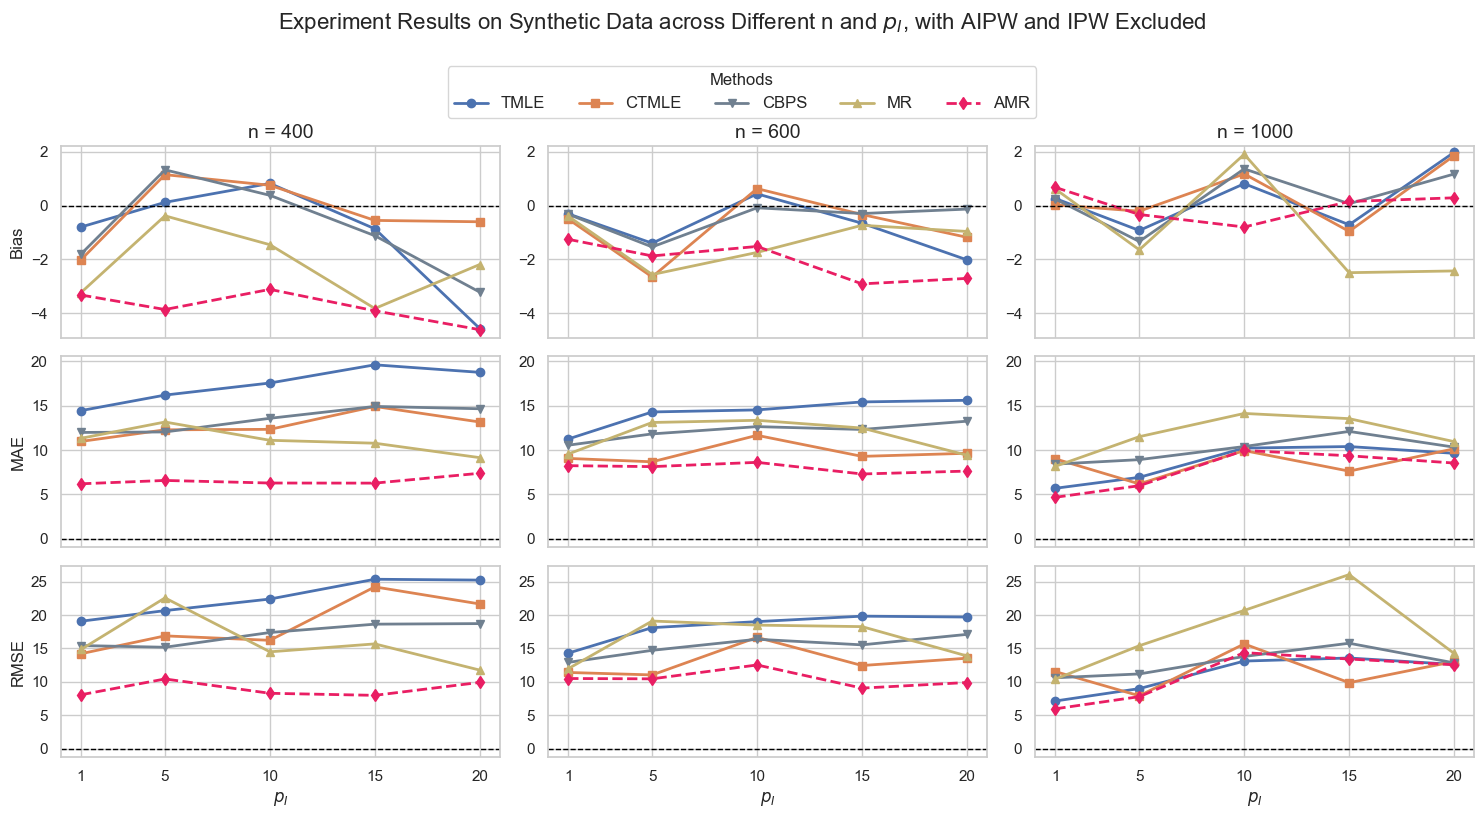

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.lines import Line2D

# ==========================================================
#  Global Settings for Colors and Markers (for consistency)
# ==========================================================
global_colors = {
    'ate_tmle':  "#4C72B0",  # deep blue
    'ate_ctmle': "#DD8452",  # orange
    'ate_cbps':  "#708090",  # slate gray
    'ate_ipw':   "#FF7F50",  # coral
    'ate_aipw':  "#009688",  # teal
    'ate_mr':    "#C4B370",  # mustard (brownish/gold)
    'ate_amr':   "#E91E63",  # hot pink
}

default_markers = ["o", "s", "v", "^", "d", "P", "X"]

def get_disp_label(method):
    return "DOPE" if method == "ate_sioapw" else method.replace("ate_", "").upper()

# ==========================================================
# 1. Plotting ATE Metrics: Bias, MAE, RMSE
# ==========================================================
n_list = [400, 600, 1000]
p_instr_list = [1, 5, 10, 15, 20]
methods = [
    'ate_tmle', 'ate_ctmle', 'ate_cbps', 'ate_ipw', 'ate_aipw',
    'ate_mr', 'ate_amr', 'ate_siaipw', 'ate_sioapw', 'ate_siobpw'
]

summary = {n: {} for n in n_list}
for n in n_list:
    for p_instr in p_instr_list:
        print("n: ",n)
        print("p: ",p_instr)
        filename = f"results/CollaborativeLearning/causl_non_linear/ate_n{n}_s{p_instr}.joblib"

        try:
            ate_results = joblib.load(filename)
        except Exception as e:
            print(f"Could not load {filename}: {e}")
            continue

        true_ate = np.array(ate_results['true_ate'])
        summary[n][p_instr] = {}
        for method in methods:
            estimates = np.array(ate_results[method])
            bias = estimates - true_ate
            abs_bias = np.abs(bias)
            summary[n][p_instr][method] = {
                'bias_mean': np.mean(bias),
                'bias_std': np.std(bias, ddof=1),
                'abs_bias_mean': np.mean(abs_bias),
                'abs_bias_std': np.std(abs_bias, ddof=1),
                'rmse': np.sqrt(np.mean(bias**2))
            }

exclude_plot = ['ate_siaipw', 'ate_sioapw', 'ate_siobpw','ate_aipw','ate_ipw']
plot_methods = [m for m in methods if m not in exclude_plot]
colors = {m: global_colors[m] for m in plot_methods}
marker_map = dict(zip(plot_methods, default_markers))

sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=len(n_list), figsize=(5*len(n_list), 8), sharex='col')

for col_idx, n in enumerate(n_list):
    for method in plot_methods:
        x_vals, bias_mean_list, mae_list, rmse_list = [], [], [], []
        for p in p_instr_list:
            if p in summary[n]:
                data = summary[n][p].get(method, None)
                if data is not None:
                    x_vals.append(p)
                    bias_mean_list.append(data['bias_mean'])
                    mae_list.append(data['abs_bias_mean'])
                    rmse_list.append(data['rmse'])
        if not x_vals:
            continue
        x_vals = np.array(x_vals)
        if method == "ate_amr":
            ls = '--'
            lw = 2
            ms = 6
        else:
            ls = '-'
            lw = 2
            ms = 6
        # Top row: Bias
        axes[0, col_idx].plot(x_vals, bias_mean_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
        # Middle row: MAE
        axes[1, col_idx].plot(x_vals, mae_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
        # Bottom row: RMSE
        axes[2, col_idx].plot(x_vals, rmse_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
    
    axes[0, col_idx].set_title(f"n = {n}", fontsize=14)
    axes[2, col_idx].set_xlabel(r"$p_I$", fontsize=12)
    for row in range(3):
        axes[row, col_idx].set_xticks(p_instr_list)
        # Add horizontal line at y=0 in every row.
        axes[row, col_idx].axhline(y=0, color='black', linestyle='--', lw=1)

# Set same y-axis limits for each row across columns.
for row in range(3):
    ymins = [axes[row, j].get_ylim()[0] for j in range(len(n_list))]
    ymaxs = [axes[row, j].get_ylim()[1] for j in range(len(n_list))]
    common_min = min(ymins)
    common_max = max(ymaxs)
    for j in range(len(n_list)):
        axes[row, j].set_ylim(common_min, common_max)

axes[0, 0].set_ylabel("Bias", fontsize=12)
axes[1, 0].set_ylabel("MAE", fontsize=12)
axes[2, 0].set_ylabel("RMSE", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.90])
legend_elements = []
for m in plot_methods:
    ls = '--' if m == "ate_amr" else '-'
    legend_elements.append(Line2D([0], [0],
                                  color=colors[m],
                                  lw=2,
                                  marker=marker_map[m],
                                  markersize=6,
                                  ls=ls,
                                  label=get_disp_label(m)))
fig.legend(handles=legend_elements, loc='upper center', ncol=len(plot_methods),
           fontsize=12, title="Methods", title_fontsize=12, bbox_to_anchor=(0.5, 0.96))

plt.suptitle("Experiment Results on Synthetic Data across Different n and $p_I$, with AIPW and IPW Excluded", fontsize=16, y=1.02)
plt.show()


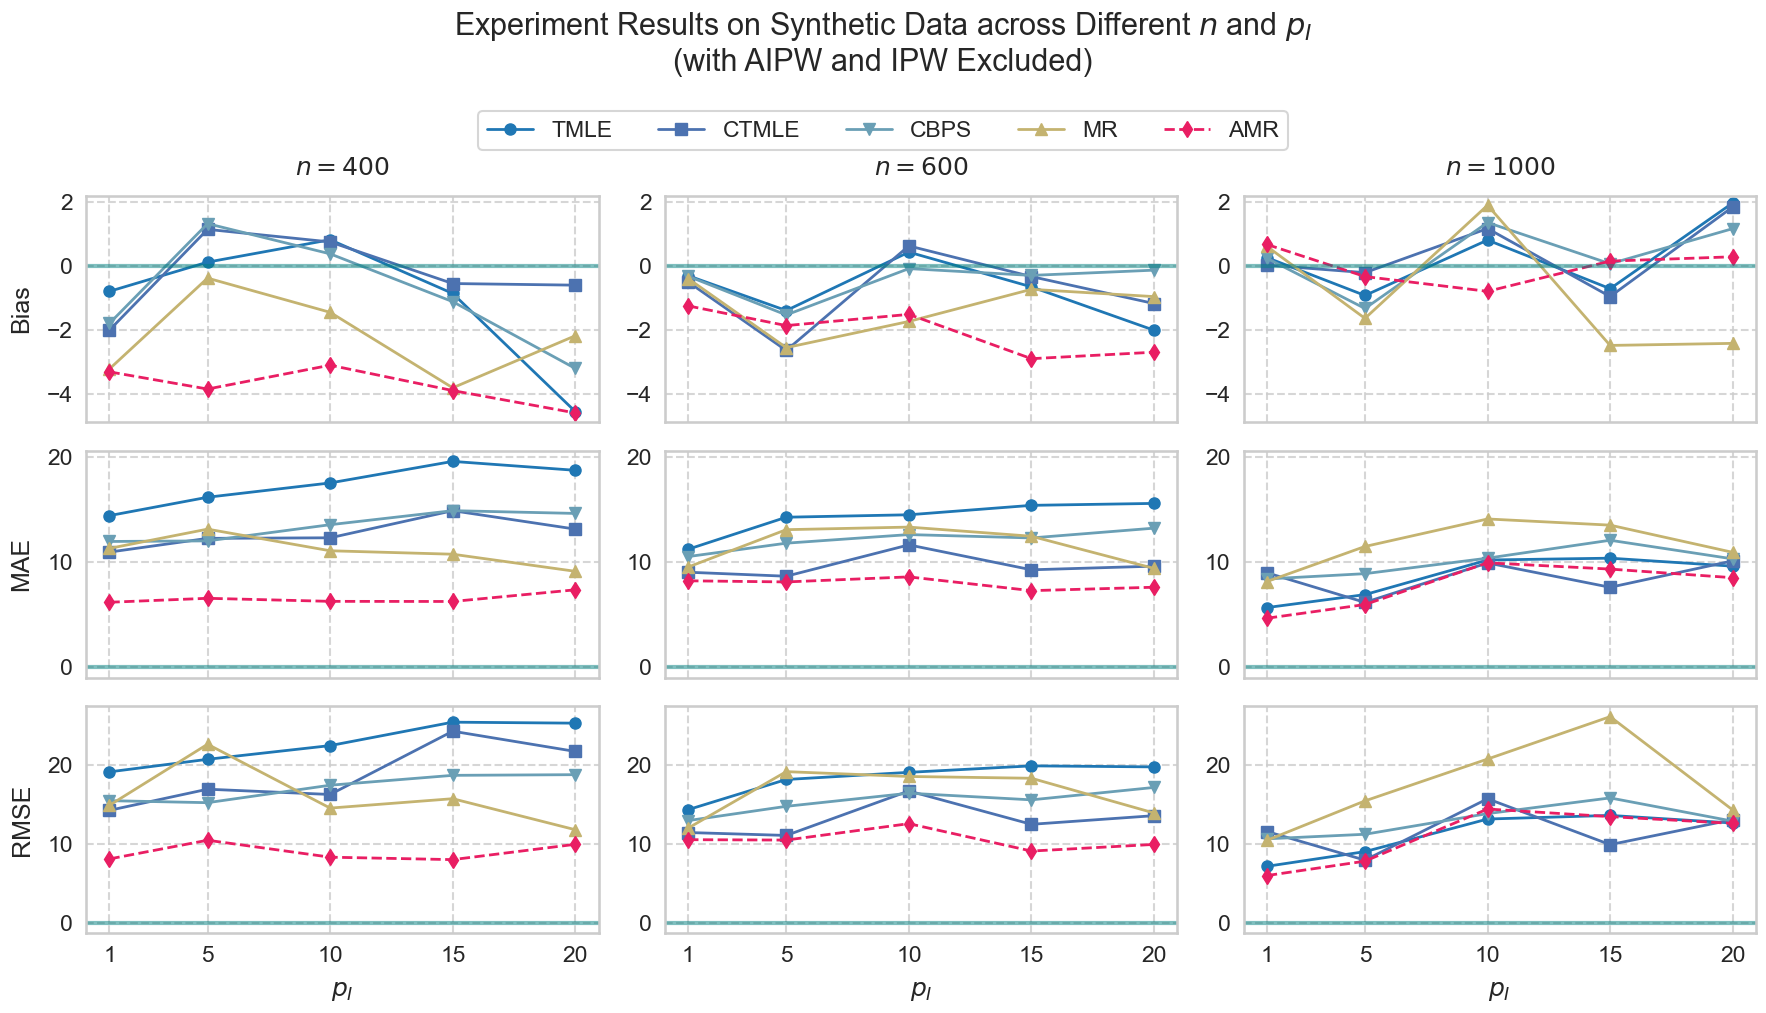

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.lines import Line2D

# ==========================================================
#  Global Settings for Colors and Markers (for consistency)
# ==========================================================
global_colors = {
    'ate_tmle':  "#1F77B4",  # standard blue
    'ate_ctmle': "#4C72B0",  # deep blue
    'ate_cbps':  "#6A9FB5",  # muted blue
    'ate_ipw':   "#5B8DB8",  # steel blue
    'ate_aipw':  "#4682B4",  # darker steel blue
    'ate_mr':    "#C4B370",  # mustard (brownish/gold)
    'ate_amr':   "#E91E63",  # hot pink
}

default_markers = ["o", "s", "v", "^", "d", "P", "X"]

def get_disp_label(method):
    return "DOPE" if method == "ate_sioapw" else method.replace("ate_", "").upper()

# Set custom fonts and styles via rcParams for a professional look.
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.labelsize": 18,
    "axes.titlesize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "figure.titlesize": 22
})

# ==========================================================
# 1. Plotting ATE Metrics: Bias, MAE, RMSE
# ==========================================================
n_list = [400, 600, 1000]
p_instr_list = [1, 5, 10, 15, 20]
methods = [
    'ate_tmle', 'ate_ctmle', 'ate_cbps', 'ate_ipw', 'ate_aipw',
    'ate_mr', 'ate_amr', 'ate_siaipw', 'ate_sioapw', 'ate_siobpw'
]

# Load and compute summary metrics.
summary = {n: {} for n in n_list}
for n in n_list:
    for p_instr in p_instr_list:
        filename = f"results/CollaborativeLearning/causl_non_linear/ate_n{n}_s{p_instr}.joblib"
        try:
            ate_results = joblib.load(filename)
        except Exception as e:
            print(f"Could not load {filename}: {e}")
            continue

        true_ate = np.array(ate_results['true_ate'])
        summary[n][p_instr] = {}
        for method in methods:
            estimates = np.array(ate_results[method])
            bias = estimates - true_ate
            abs_bias = np.abs(bias)
            summary[n][p_instr][method] = {
                'bias_mean': np.mean(bias),
                'bias_std': np.std(bias, ddof=1),
                'abs_bias_mean': np.mean(abs_bias),
                'abs_bias_std': np.std(abs_bias, ddof=1),
                'rmse': np.sqrt(np.mean(bias**2))
            }

# Exclude some methods from plotting.
exclude_plot = ['ate_siaipw', 'ate_sioapw', 'ate_siobpw','ate_aipw','ate_ipw']
plot_methods = [m for m in methods if m not in exclude_plot]
colors = {m: global_colors[m] for m in plot_methods}
marker_map = dict(zip(plot_methods, default_markers))

# Use a clean Seaborn theme.
sns.set_theme(style="whitegrid", context="talk")

fig, axes = plt.subplots(nrows=3, ncols=len(n_list), figsize=(6*len(n_list), 10), sharex='col')

# Loop over sample sizes and plot each metric.
for col_idx, n in enumerate(n_list):
    for method in plot_methods:
        x_vals, bias_mean_list, mae_list, rmse_list = [], [], [], []
        for p in p_instr_list:
            if p in summary[n]:
                data = summary[n][p].get(method, None)
                if data is not None:
                    x_vals.append(p)
                    bias_mean_list.append(data['bias_mean'])
                    mae_list.append(data['abs_bias_mean'])
                    rmse_list.append(data['rmse'])
        if not x_vals:
            continue
        x_vals = np.array(x_vals)
        # Different linestyle for "ate_amr" if needed.
        ls = '--' if method == "ate_amr" else '-'
        lw = 2
        ms = 8
        # Plot Bias
        axes[0, col_idx].plot(x_vals, bias_mean_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
        # Plot MAE
        axes[1, col_idx].plot(x_vals, mae_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
        # Plot RMSE
        axes[2, col_idx].plot(x_vals, rmse_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
    
    # Titles and labels for each column.
    axes[0, col_idx].set_title(f"$n = {n}$", pad=15)
    axes[2, col_idx].set_xlabel(r"$p_I$", labelpad=10)
    for row in range(3):
        axes[row, col_idx].set_xticks(p_instr_list)
        axes[row, col_idx].tick_params(axis="both", which="both", length=6)
        # Draw a more prominent horizontal zero line.
        axes[row, col_idx].axhline(y=0, color='teal', linestyle='-', lw=3, alpha=0.5)
        # Light grid lines.
        axes[row, col_idx].grid(True, linestyle='--', alpha=0.8)

# Set consistent y-axis limits for each row.
for row in range(3):
    ymins = [axes[row, j].get_ylim()[0] for j in range(len(n_list))]
    ymaxs = [axes[row, j].get_ylim()[1] for j in range(len(n_list))]
    common_min = min(ymins)
    common_max = max(ymaxs)
    for j in range(len(n_list)):
        axes[row, j].set_ylim(common_min, common_max)

axes[0, 0].set_ylabel("Bias", labelpad=10)
axes[1, 0].set_ylabel("MAE", labelpad=10)
axes[2, 0].set_ylabel("RMSE", labelpad=10)

plt.tight_layout(rect=[0, 0, 1, 0.90])

# Create a centered legend.
legend_elements = []
for m in plot_methods:
    ls = '--' if m == "ate_amr" else '-'
    legend_elements.append(Line2D([0], [0],
                                  color=colors[m],
                                  lw=2,
                                  marker=marker_map[m],
                                  markersize=ms,
                                  ls=ls,
                                  label=get_disp_label(m)))
fig.legend(handles=legend_elements, loc='upper center', ncol=len(plot_methods),
           bbox_to_anchor=(0.5, 0.93))

plt.suptitle("Experiment Results on Synthetic Data across Different $n$ and $p_I$\n(with AIPW and IPW Excluded)", y=1.02)
plt.show()


In [148]:
import numpy as np
import pandas as pd
import joblib

# ---------------------------
# Create LaTeX Tables for Bias, MAE, and RMSE
# ---------------------------

# Global settings and lists
n_list = [400, 600, 1000]
p_instr_list = [1, 5, 10, 15, 20]

# Updated methods list:
# Drop 'ate_siaipw' and 'ate_siobpw'; and place 'ate_sioapw' (DOPE) before 'ate_mr'
methods = [
    'ate_tmle', 'ate_ctmle', 'ate_cbps', 'ate_ipw', 'ate_aipw',
    'ate_sioapw',  # DOPE column; will be displayed as DOPE by get_disp_label below
    'ate_mr', 'ate_amr'
]

def get_disp_label(method):
    return "DOPE" if method == "ate_sioapw" else method.replace("ate_", "").upper()

# We assume that a dictionary called `summary` has been created earlier (as in your provided code)
# where summary[n][p_instr][method] contains the keys: 'bias_mean', 'abs_bias_mean', 'rmse'

# Build rows for the Bias, MAE, and RMSE tables.
rows_bias = []
rows_mae  = []
rows_rmse = []

for n in n_list:
    for p in p_instr_list:
        if p not in summary[n]:
            continue
        row_bias = {"n": n, "p_I": p}
        row_mae  = {"n": n, "p_I": p}
        row_rmse = {"n": n, "p_I": p}
        for method in methods:
            disp_label = get_disp_label(method)
            if method in summary[n][p]:
                bias_val = summary[n][p][method]['bias_mean']
                mae_val  = summary[n][p][method]['abs_bias_mean']
                rmse_val = summary[n][p][method]['rmse']  # use RMSE directly
                # Format with three significant digits and wrap in $$.
                row_bias[disp_label] = f"$ {bias_val:.3g} $"
                row_mae[disp_label]  = f"$ {mae_val:.3g} $"
                row_rmse[disp_label] = f"$ {rmse_val:.3g} $"
            else:
                row_bias[disp_label] = ""
                row_mae[disp_label]  = ""
                row_rmse[disp_label] = ""
        rows_bias.append(row_bias)
        rows_mae.append(row_mae)
        rows_rmse.append(row_rmse)

# Create DataFrames and set a multi-index on n and p_I.
df_bias = pd.DataFrame(rows_bias).set_index(["n", "p_I"])
df_mae  = pd.DataFrame(rows_mae).set_index(["n", "p_I"])
df_rmse = pd.DataFrame(rows_rmse).set_index(["n", "p_I"])

# Set the column format: one "r" for each index level plus one "r" per column.
col_format_bias = "r" * (df_bias.index.nlevels + len(df_bias.columns))
col_format_mae  = "r" * (df_mae.index.nlevels  + len(df_mae.columns))
col_format_rmse = "r" * (df_rmse.index.nlevels  + len(df_rmse.columns))

# Convert DataFrames to LaTeX tables.
latex_bias = df_bias.to_latex(multirow=True, escape=False, column_format=col_format_bias)
latex_mae  = df_mae.to_latex(multirow=True, escape=False, column_format=col_format_mae)
latex_rmse = df_rmse.to_latex(multirow=True, escape=False, column_format=col_format_rmse)

# Wrap each table in a table environment with resizing.
latex_bias = (
    "\\begin{table}[ht]\n\\begin{center}\n"
    "\\resizebox{\\textwidth}{!}{%\n" + latex_bias + "\n}\n"
    "\\end{center}\n\\end{table}"
)
latex_mae = (
    "\\begin{table}[ht]\n\\begin{center}\n"
    "\\resizebox{\\textwidth}{!}{%\n" + latex_mae + "\n}\n"
    "\\end{center}\n\\end{table}"
)
latex_rmse = (
    "\\begin{table}[ht]\n\\begin{center}\n"
    "\\resizebox{\\textwidth}{!}{%\n" + latex_rmse + "\n}\n"
    "\\end{center}\n\\end{table}"
)

# Print the LaTeX code for the tables.
print("Bias Table:")
print(latex_bias)
print("\nMAE Table:")
print(latex_mae)
print("\nRMSE Table:")
print(latex_rmse)


Bias Table:
\begin{table}[ht]
\begin{center}
\resizebox{\textwidth}{!}{%
\begin{tabular}{rrrrrrrrrr}
\toprule
 &  & TMLE & CTMLE & CBPS & IPW & AIPW & DOPE & MR & AMR \\
n & p_I &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{400} & 1 & $ -0.795 $ & $ -2.01 $ & $ -1.8 $ & $ -3.25 $ & $ -1.99 $ & $ 103 $ & $ -3.23 $ & $ -3.32 $ \\
 & 5 & $ 0.121 $ & $ 1.15 $ & $ 1.33 $ & $ 14.9 $ & $ 10.9 $ & $ 103 $ & $ -0.38 $ & $ -3.86 $ \\
 & 10 & $ 0.823 $ & $ 0.754 $ & $ 0.381 $ & $ 2.23 $ & $ 2.52 $ & $ 103 $ & $ -1.45 $ & $ -3.11 $ \\
 & 15 & $ -0.862 $ & $ -0.55 $ & $ -1.12 $ & $ 14.6 $ & $ 7.14 $ & $ 103 $ & $ -3.82 $ & $ -3.91 $ \\
 & 20 & $ -4.56 $ & $ -0.601 $ & $ -3.21 $ & $ -156 $ & $ -165 $ & $ 104 $ & $ -2.19 $ & $ -4.61 $ \\
\cline{1-10}
\multirow[t]{5}{*}{600} & 1 & $ -0.305 $ & $ -0.501 $ & $ -0.322 $ & $ 0.118 $ & $ -0.309 $ & $ 103 $ & $ -0.396 $ & $ -1.25 $ \\
 & 5 & $ -1.4 $ & $ -2.65 $ & $ -1.53 $ & $ -5.5 $ & $ -1.88 $ & $ 102 $ & $ -2.56 $ & $ -1.87 $ \\
 & 10 & $ 0.435

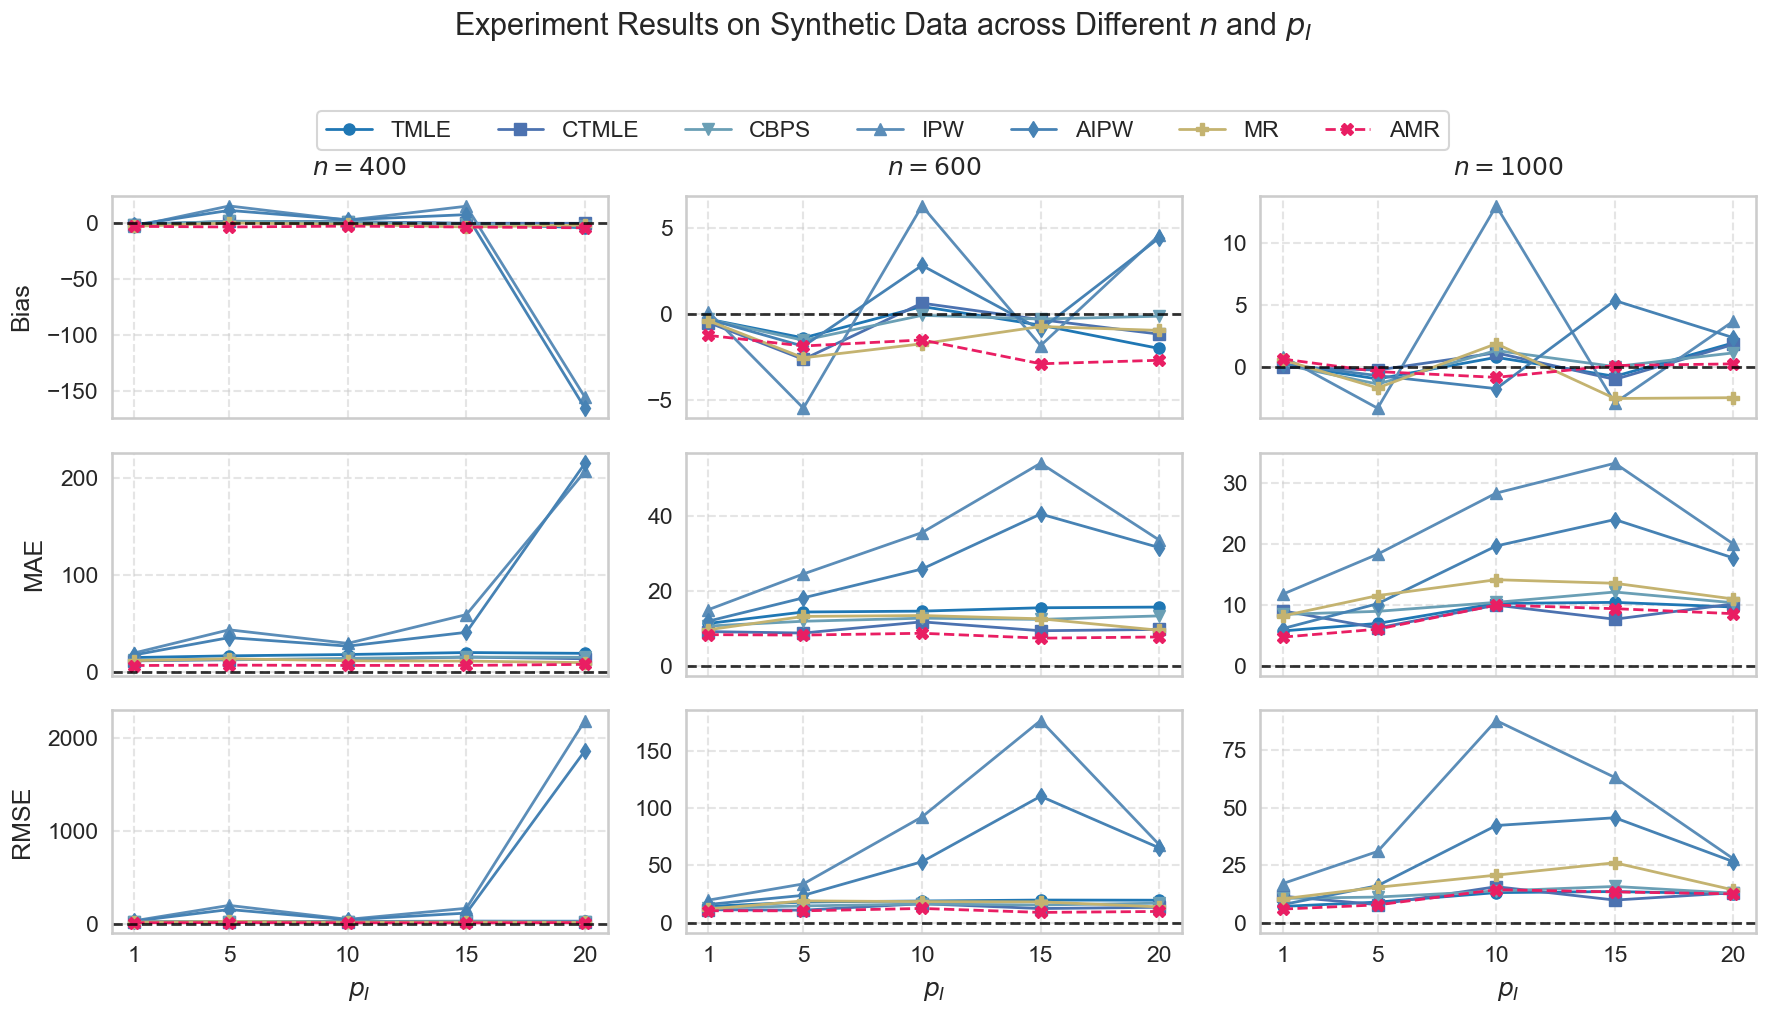

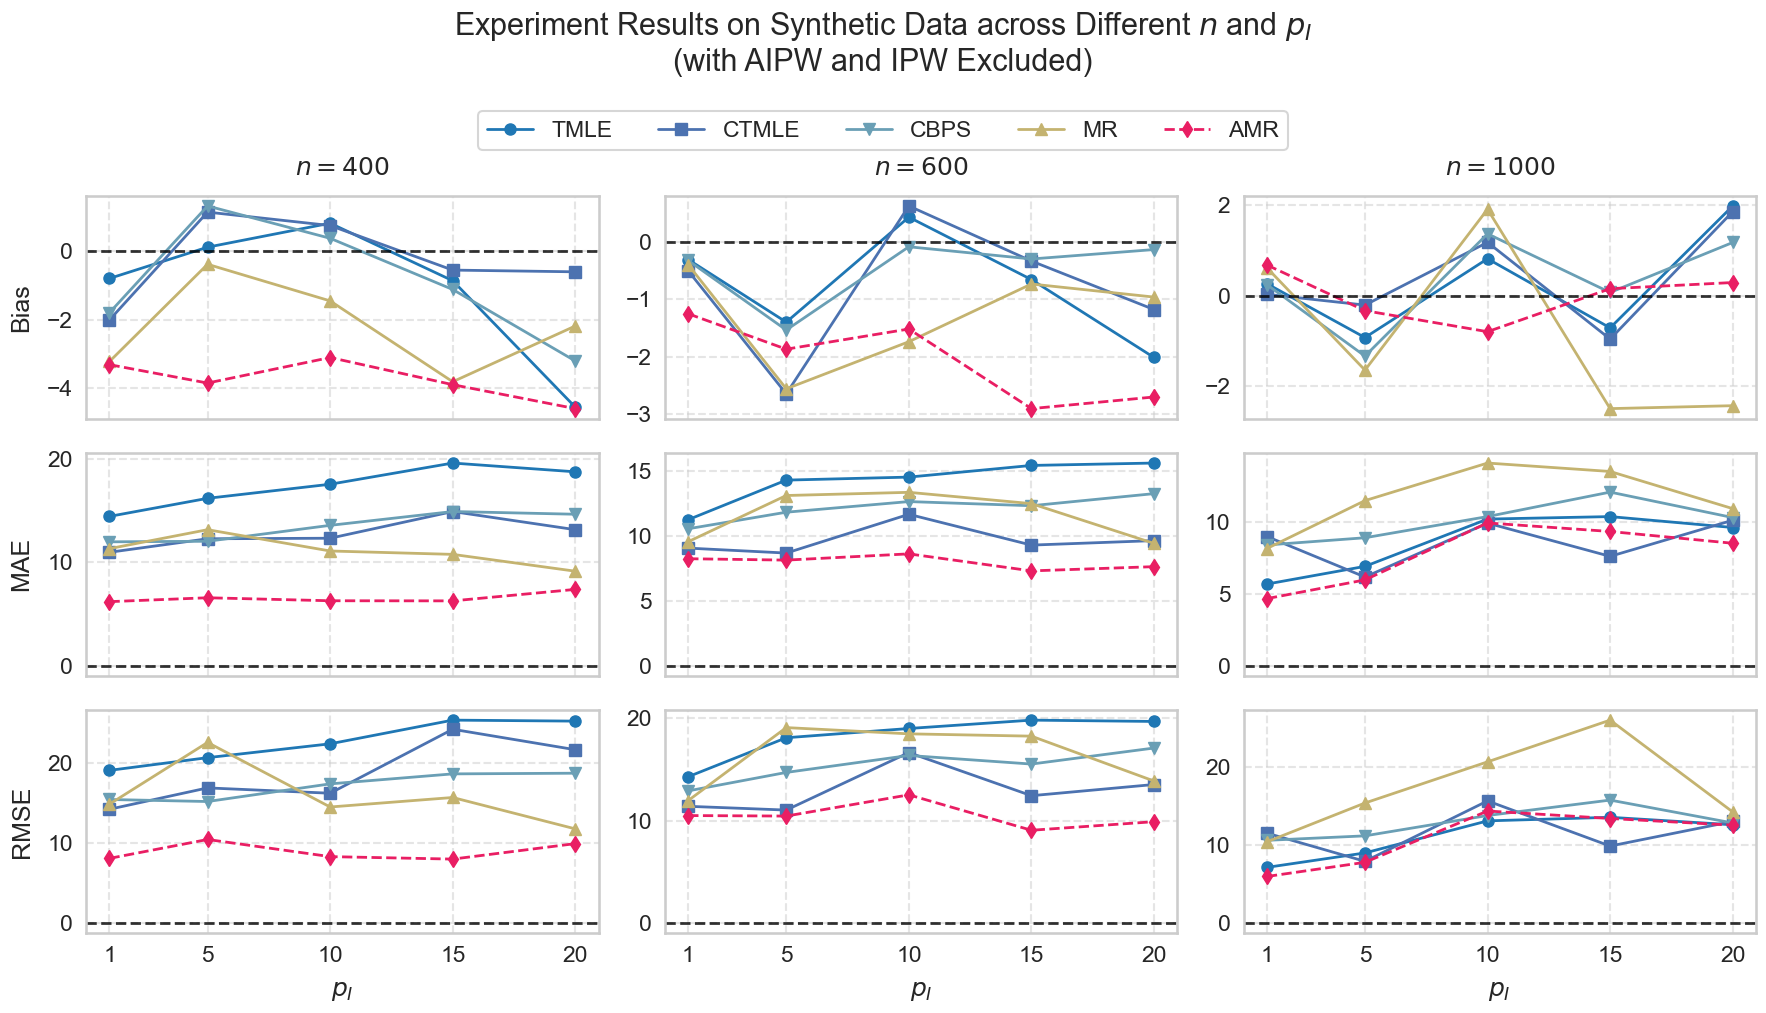

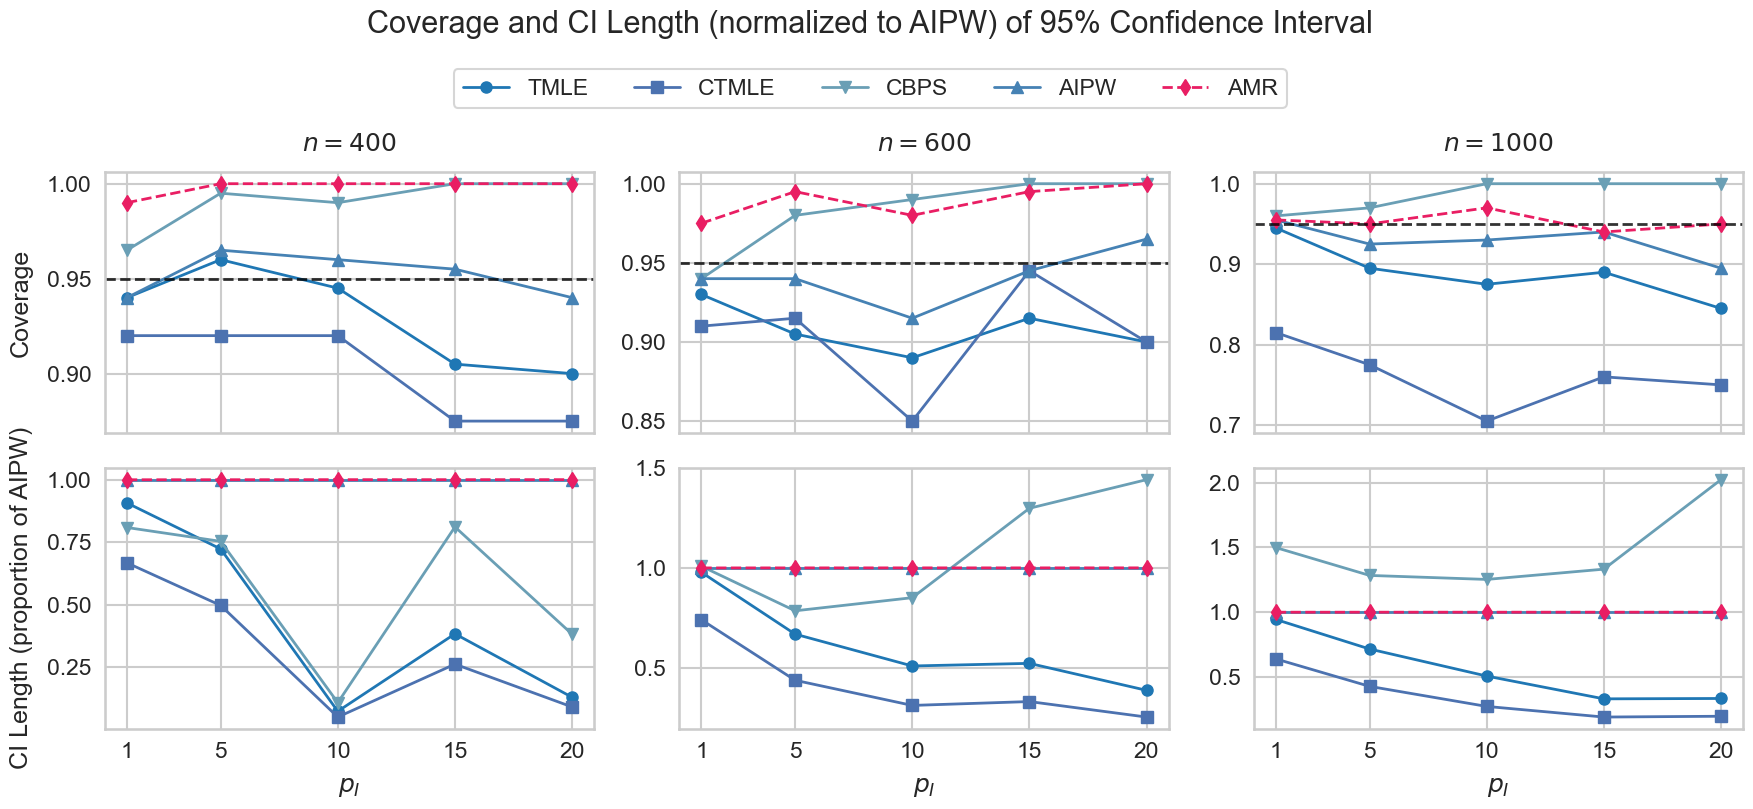

\begin{table}[ht]
\begin{center}
\resizebox{\textwidth}{!}{%
\begin{tabular}{rrrrrrr}
\toprule
 &  & TMLE & CTMLE & CBPS & AIPW & AMR \\
n & p_I &  &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{400} & 1 & $$ 0.94 $$ & $$ 0.92 $$ & $$ 0.965 $$ & $$ 0.94 $$ & $$ 0.99 $$ \\
 & 5 & $$ 0.96 $$ & $$ 0.92 $$ & $$ 0.995 $$ & $$ 0.965 $$ & $$ 1 $$ \\
 & 10 & $$ 0.945 $$ & $$ 0.92 $$ & $$ 0.99 $$ & $$ 0.96 $$ & $$ 1 $$ \\
 & 15 & $$ 0.905 $$ & $$ 0.875 $$ & $$ 1 $$ & $$ 0.955 $$ & $$ 1 $$ \\
 & 20 & $$ 0.9 $$ & $$ 0.875 $$ & $$ 1 $$ & $$ 0.94 $$ & $$ 1 $$ \\
\cline{1-7}
\multirow[t]{5}{*}{600} & 1 & $$ 0.93 $$ & $$ 0.91 $$ & $$ 0.94 $$ & $$ 0.94 $$ & $$ 0.975 $$ \\
 & 5 & $$ 0.905 $$ & $$ 0.915 $$ & $$ 0.98 $$ & $$ 0.94 $$ & $$ 0.995 $$ \\
 & 10 & $$ 0.89 $$ & $$ 0.85 $$ & $$ 0.99 $$ & $$ 0.915 $$ & $$ 0.98 $$ \\
 & 15 & $$ 0.915 $$ & $$ 0.945 $$ & $$ 1 $$ & $$ 0.945 $$ & $$ 0.995 $$ \\
 & 20 & $$ 0.9 $$ & $$ 0.9 $$ & $$ 1 $$ & $$ 0.965 $$ & $$ 1 $$ \\
\cline{1-7}
\multirow[t]{5}{*}{1000} & 1 & $$ 

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.lines import Line2D

# ==========================================================
#  Global Settings for Colors and Markers (for consistency)
# ==========================================================
global_colors = {
    'ate_tmle':  "#1F77B4",  # standard blue
    'ate_ctmle': "#4C72B0",  # deep blue
    'ate_cbps':  "#6A9FB5",  # muted blue
    'ate_ipw':   "#5B8DB8",  # steel blue
    'ate_aipw':  "#4682B4",  # darker steel blue
    'ate_mr':    "#C4B370",  # mustard (brownish/gold)
    'ate_amr':   "#E91E63",  # hot pink
}



default_markers = ["o", "s", "v", "^", "d", "P", "X"]

def get_disp_label(method):
    return "DOPE" if method == "ate_sioapw" else method.replace("ate_", "").upper()

# Set custom fonts and styles via rcParams for a professional look.
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.labelsize": 18,
    "axes.titlesize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "figure.titlesize": 22
})

# ==========================================================
# 1. Plotting ATE Metrics: Bias, MAE, RMSE
# ==========================================================
n_list = [400, 600, 1000]
p_instr_list = [1, 5, 10, 15, 20]
methods = [
    'ate_tmle', 'ate_ctmle', 'ate_cbps', 'ate_ipw', 'ate_aipw',
    'ate_mr', 'ate_amr', 'ate_siaipw', 'ate_sioapw', 'ate_siobpw'
]

# Aggregate summary statistics into a nested dictionary.
summary = {n: {} for n in n_list}
for n in n_list:
    for p_instr in p_instr_list:
        filename = f"results/CollaborativeLearning/causl_non_linear/ate_n{n}_s{p_instr}.joblib"
        try:
            ate_results = joblib.load(filename)
        except Exception as e:
            print(f"Could not load {filename}: {e}")
            continue

        true_ate = np.array(ate_results['true_ate'])
        summary[n][p_instr] = {}
        for method in methods:
            estimates = np.array(ate_results[method])
            bias = estimates - true_ate
            abs_bias = np.abs(bias)
            summary[n][p_instr][method] = {
                'bias_mean': np.mean(bias),
                'bias_std': np.std(bias, ddof=1),
                'abs_bias_mean': np.mean(abs_bias),
                'abs_bias_std': np.std(abs_bias, ddof=1),
                'rmse': np.sqrt(np.mean(bias**2))
            }

# Exclude some methods from plotting.
exclude_plot = ['ate_siaipw', 'ate_sioapw', 'ate_siobpw']
plot_methods = [m for m in methods if m not in exclude_plot]
colors = {m: global_colors[m] for m in plot_methods}
marker_map = dict(zip(plot_methods, default_markers))

# Use a clean Seaborn theme.
sns.set_theme(style="whitegrid", context="talk")

fig, axes = plt.subplots(nrows=3, ncols=len(n_list), figsize=(6*len(n_list), 10), sharex='col')

for col_idx, n in enumerate(n_list):
    for method in plot_methods:
        x_vals, bias_mean_list, mae_list, rmse_list = [], [], [], []
        for p in p_instr_list:
            if p in summary[n]:
                data = summary[n][p].get(method, None)
                if data is not None:
                    x_vals.append(p)
                    bias_mean_list.append(data['bias_mean'])
                    mae_list.append(data['abs_bias_mean'])
                    rmse_list.append(data['rmse'])
        if not x_vals:
            continue
        x_vals = np.array(x_vals)
        # For "ate_amr", use dashed line.
        ls = '--' if method == "ate_amr" else '-'
        lw = 2
        ms = 8
        # Plot Bias
        axes[0, col_idx].plot(x_vals, bias_mean_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
        # Plot MAE
        axes[1, col_idx].plot(x_vals, mae_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
        # Plot RMSE
        axes[2, col_idx].plot(x_vals, rmse_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
    
    axes[0, col_idx].set_title(f"$n = {n}$", pad=15)
    axes[2, col_idx].set_xlabel(r"$p_I$", labelpad=10)
    for row in range(3):
        axes[row, col_idx].set_xticks(p_instr_list)
        axes[row, col_idx].tick_params(axis="both", which="both", length=6)
        # Enhanced horizontal zero line.
        axes[row, col_idx].axhline(y=0, color='black', linestyle='--', lw=2, alpha=0.8)
        axes[row, col_idx].grid(True, linestyle='--', alpha=0.5)

axes[0, 0].set_ylabel("Bias", labelpad=10)
axes[1, 0].set_ylabel("MAE", labelpad=10)
axes[2, 0].set_ylabel("RMSE", labelpad=10)

plt.tight_layout(rect=[0, 0, 1, 0.90])
# Create one overall legend and move it slightly lower.
legend_elements = []
for m in plot_methods:
    ls = '--' if m == "ate_amr" else '-'
    legend_elements.append(Line2D([0], [0],
                                  color=colors[m],
                                  lw=2,
                                  marker=marker_map[m],
                                  markersize=ms,
                                  ls=ls,
                                  label=get_disp_label(m)))
fig.legend(handles=legend_elements, loc='upper center', ncol=len(plot_methods),
           bbox_to_anchor=(0.5, 0.93))
plt.suptitle("Experiment Results on Synthetic Data across Different $n$ and $p_I$", y=1.02)
plt.show()

# ==========================================================
# 2. (Optional) Second Plot – Similar ATE Metrics Plot
# ==========================================================
# In this second plot we exclude a few more methods.
exclude_plot = ['ate_aipw','ate_ipw','ate_siaipw', 'ate_sioapw', 'ate_siobpw']
plot_methods = [m for m in methods if m not in exclude_plot]
# Re-use colors and markers for these methods.
colors = {m: global_colors[m] for m in plot_methods}
marker_map = dict(zip(plot_methods, default_markers))

fig, axes = plt.subplots(nrows=3, ncols=len(n_list), figsize=(6*len(n_list), 10), sharex='col')

for col_idx, n in enumerate(n_list):
    for method in plot_methods:
        x_vals, bias_mean_list, mae_list, rmse_list = [], [], [], []
        for p in p_instr_list:
            if p in summary[n]:
                data = summary[n][p].get(method, None)
                if data is not None:
                    x_vals.append(p)
                    bias_mean_list.append(data['bias_mean'])
                    mae_list.append(data['abs_bias_mean'])
                    rmse_list.append(data['rmse'])
        if not x_vals:
            continue
        x_vals = np.array(x_vals)
        ls = '--' if method == "ate_amr" else '-'
        lw = 2
        ms = 8
        # Plot each metric.
        axes[0, col_idx].plot(x_vals, bias_mean_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
        axes[1, col_idx].plot(x_vals, mae_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
        axes[2, col_idx].plot(x_vals, rmse_list,
                              color=colors[method],
                              marker=marker_map[method],
                              lw=lw, markersize=ms, ls=ls,
                              label=get_disp_label(method))
    axes[0, col_idx].set_title(f"$n = {n}$", pad=15)
    axes[2, col_idx].set_xlabel(r"$p_I$", labelpad=10)
    for row in range(3):
        axes[row, col_idx].set_xticks(p_instr_list)
        axes[row, col_idx].tick_params(axis="both", which="both", length=6)
        axes[row, col_idx].axhline(y=0, color='black', linestyle='--', lw=2, alpha=0.8)
        axes[row, col_idx].grid(True, linestyle='--', alpha=0.5)

axes[0, 0].set_ylabel("Bias", labelpad=10)
axes[1, 0].set_ylabel("MAE", labelpad=10)
axes[2, 0].set_ylabel("RMSE", labelpad=10)

plt.tight_layout(rect=[0, 0, 1, 0.90])
legend_elements = [Line2D([0], [0],
                          color=colors[m],
                          lw=2,
                          marker=marker_map[m],
                          markersize=ms,
                          ls='--' if m=="ate_amr" else '-',
                          label=get_disp_label(m))
                   for m in plot_methods]
fig.legend(handles=legend_elements, loc='upper center', ncol=len(plot_methods),
           bbox_to_anchor=(0.5, 0.93))
plt.suptitle("Experiment Results on Synthetic Data across Different $n$ and $p_I$\n(with AIPW and IPW Excluded)", y=1.02)
plt.show()

# ==========================================================
# 3. Plotting Coverage & CI Length (with LaTeX Tables)
# ==========================================================
n_list_cov = [400, 600, 1000]
p_instr_list = [1, 5, 10, 15, 20]
methods_cov = ['ate_tmle', 'ate_ctmle', 'ate_cbps', 'ate_aipw', 'ate_amr']
colors_cov = {m: global_colors[m] for m in methods_cov}
marker_map_cov = dict(zip(methods_cov, default_markers))

coverage_summary = {n: {} for n in n_list_cov}
length_summary   = {n: {} for n in n_list_cov}

for n in n_list_cov:
    for p_instr in p_instr_list:
        ate_filename = f"results/CollaborativeLearning/causl_non_linear/new/ate_n{n}_s{p_instr}.joblib"
        std_filename = f"results/CollaborativeLearning/causl_non_linear/new/std_n{n}_s{p_instr}.joblib"
        try:
            ate_results = joblib.load(ate_filename)
            std_results = joblib.load(std_filename)
        except Exception as e:
            print(f"Could not load {ate_filename} or {std_filename}: {e}")
            continue
        
        true_ate = np.array(ate_results['true_ate'])
        coverage_summary[n][p_instr] = {}
        length_summary[n][p_instr]   = {}
        for method in methods_cov:
            estimates = np.array(ate_results[method])
            std_key = method.replace("ate_", "std_")
            stds = np.array(std_results[std_key])
            lower = estimates - 1.96 * stds
            upper = estimates + 1.96 * stds
            coverage = np.mean((true_ate >= lower) & (true_ate <= upper))
            ci_length = np.mean(upper - lower)
            coverage_summary[n][p_instr][method] = coverage
            length_summary[n][p_instr][method]   = ci_length

sns.set_theme(style="whitegrid", context="talk")
fig, axes = plt.subplots(nrows=2, ncols=len(n_list_cov), figsize=(6*len(n_list_cov), 8), sharex='col')

default_lw = 2
default_ms = 8

for col_idx, n in enumerate(n_list_cov):
    for method in methods_cov:
        x_vals, cov_vals, len_vals = [], [], []
        for p in p_instr_list:
            if p in coverage_summary[n]:
                cov = coverage_summary[n][p].get(method, None)
                if p in length_summary[n] and length_summary[n][p].get('ate_aipw', 0) != 0:
                    ratio = length_summary[n][p][method] / length_summary[n][p]['ate_aipw']
                else:
                    ratio = None
                if cov is not None and ratio is not None:
                    x_vals.append(p)
                    cov_vals.append(cov)
                    len_vals.append(ratio)
        if not x_vals:
            continue
        x_vals = np.array(x_vals)
        ls = '--' if method == "ate_amr" else '-'
        # Top row: Coverage
        axes[0, col_idx].plot(x_vals, cov_vals,
                              color=colors_cov[method],
                              marker=marker_map_cov[method],
                              lw=default_lw, markersize=default_ms, ls=ls,
                              label=get_disp_label(method))
        # Bottom row: CI Length ratio (relative to AIPW)
        axes[1, col_idx].plot(x_vals, len_vals,
                              color=colors_cov[method],
                              marker=marker_map_cov[method],
                              lw=default_lw, markersize=default_ms, ls=ls,
                              label=get_disp_label(method))
    axes[0, col_idx].axhline(0.95, color='black', linestyle='--', lw=2, alpha=0.8)
    axes[0, col_idx].set_title(f"$n = {n}$", pad=15)
    for row in range(2):
        axes[row, col_idx].set_xticks(p_instr_list)
        axes[row, col_idx].tick_params(axis="both", which="both", length=6)
    axes[1, col_idx].set_xlabel(r"$p_I$", labelpad=10)

axes[0, 0].set_ylabel("Coverage", labelpad=10)
axes[1, 0].set_ylabel("CI Length (proportion of AIPW)", labelpad=10)

plt.tight_layout(rect=[0, 0, 1, 0.90])
legend_elements_cov = [Line2D([0], [0],
                              color=colors_cov[m],
                              lw=default_lw,
                              marker=marker_map_cov[m],
                              markersize=default_ms,
                              ls='--' if m=="ate_amr" else '-',
                              label=get_disp_label(m))
                       for m in methods_cov]
fig.legend(handles=legend_elements_cov, loc='upper center', ncol=len(methods_cov),
           bbox_to_anchor=(0.5, 0.96))
plt.suptitle(r"Coverage and CI Length (normalized to AIPW) of 95% Confidence Interval", y=1.02)
plt.show()

# ---------------------------
# Creating LaTeX Tables (Coverage & CI Length)
# ---------------------------
rows_cov = []
rows_len = []

for n in n_list_cov:
    for p in p_instr_list:
        if p not in coverage_summary[n]:
            continue
        row_cov = {"n": n, "p_I": p}
        row_len = {"n": n, "p_I": p}
        for method in methods_cov:
            disp_label = get_disp_label(method)
            if method in coverage_summary[n][p]:
                cov_val = coverage_summary[n][p][method]
                if 'ate_aipw' in length_summary[n][p] and length_summary[n][p]['ate_aipw'] != 0:
                    len_ratio = length_summary[n][p][method] / length_summary[n][p]['ate_aipw']
                else:
                    len_ratio = None
                row_cov[disp_label] = f"$$ {cov_val:.3g} $$"
                row_len[disp_label] = f"$$ {len_ratio:.3g} $$" if len_ratio is not None else ""
            else:
                row_cov[disp_label] = ""
                row_len[disp_label] = ""
        rows_cov.append(row_cov)
        rows_len.append(row_len)

df_cov = pd.DataFrame(rows_cov).set_index(["n", "p_I"])
df_len = pd.DataFrame(rows_len).set_index(["n", "p_I"])

col_format_cov = "r" * (df_cov.index.nlevels + len(df_cov.columns))
col_format_len = "r" * (df_len.index.nlevels + len(df_len.columns))

latex_cov = df_cov.to_latex(multirow=True, escape=False, column_format=col_format_cov)
latex_len = df_len.to_latex(multirow=True, escape=False, column_format=col_format_len)

latex_cov = "\\begin{table}[ht]\n\\begin{center}\n" + \
            "\\resizebox{\\textwidth}{!}{%\n" + latex_cov + "\n}" + \
            "\n\\end{center}\n\\end{table}"
latex_len = "\\begin{table}[ht]\n\\begin{center}\n" + \
            "\\resizebox{\\textwidth}{!}{%\n" + latex_len + "\n}" + \
            "\n\\end{center}\n\\end{table}"

print(latex_cov)
print(latex_len)


In [140]:
import pandas as pd

# Example lists (adjust as needed)
n_list = [400, 600, 1000]
p_instr_list = [1, 5, 10, 15, 20]
methods = [
    'ate_tmle', 'ate_ctmle', 'ate_cbps', 'ate_ipw', 'ate_aipw',
    'ate_mr', 'ate_amr', 'ate_siaipw', 'ate_sioapw', 'ate_siobpw'
]

# Example helper to get display labels for methods.
# Replace or modify this function as needed.
def get_disp_label(method):
    # For instance, remove the "ate_" prefix for display purposes.
    return method.replace("ate_", "")

# Initialize rows for each table
rows_bias = []
rows_mae = []
rows_mse = []

# Loop over n and p.
# (We assume that bias_summary, mae_summary, and mse_summary have the same structure.)
for n in n_list:
    for p in p_instr_list:
        # If this (n, p) combination is missing, skip it.
        if p not in bias_summary[n]:
            continue

        row_bias = {"n": n, "p_I": p}
        row_mae = {"n": n, "p_I": p}
        row_mse = {"n": n, "p_I": p}
        for method in methods:
            disp_label = get_disp_label(method)
            if method in bias_summary[n][p]:
                bias_val = bias_summary[n][p][method]
                mae_val = mae_summary[n][p][method]
                mse_val = mse_summary[n][p][method]
                # Format with three significant digits and wrap in $$.
                row_bias[disp_label] = f"$$ {bias_val:.3g} $$"
                row_mae[disp_label] = f"$$ {mae_val:.3g} $$"
                row_mse[disp_label] = f"$$ {mse_val:.3g} $$"
            else:
                row_bias[disp_label] = ""
                row_mae[disp_label] = ""
                row_mse[disp_label] = ""
        rows_bias.append(row_bias)
        rows_mae.append(row_mae)
        rows_mse.append(row_mse)

# Create DataFrames and set index
df_bias = pd.DataFrame(rows_bias).set_index(["n", "p_I"])
df_mae = pd.DataFrame(rows_mae).set_index(["n", "p_I"])
df_mse = pd.DataFrame(rows_mse).set_index(["n", "p_I"])

# Determine column format (all columns right-aligned)
col_format_bias = "r" * (df_bias.index.nlevels + len(df_bias.columns))
col_format_mae = "r" * (df_mae.index.nlevels + len(df_mae.columns))
col_format_mse = "r" * (df_mse.index.nlevels + len(df_mse.columns))

# Convert DataFrames to LaTeX code.
latex_bias = df_bias.to_latex(multirow=True, escape=False, column_format=col_format_bias)
latex_mae = df_mae.to_latex(multirow=True, escape=False, column_format=col_format_mae)
latex_mse = df_mse.to_latex(multirow=True, escape=False, column_format=col_format_mse)

# Wrap in table environment and resize to text width.
latex_bias = (
    "\\begin{table}[ht]\n\\begin{center}\n"
    "\\resizebox{\\textwidth}{!}{%\n" + latex_bias + "\n}\n"
    "\\end{center}\n\\end{table}"
)
latex_mae = (
    "\\begin{table}[ht]\n\\begin{center}\n"
    "\\resizebox{\\textwidth}{!}{%\n" + latex_mae + "\n}\n"
    "\\end{center}\n\\end{table}"
)
latex_mse = (
    "\\begin{table}[ht]\n\\begin{center}\n"
    "\\resizebox{\\textwidth}{!}{%\n" + latex_mse + "\n}\n"
    "\\end{center}\n\\end{table}"
)

# Print the resulting LaTeX code.
print(latex_bias)
print(latex_mae)
print(latex_mse)


NameError: name 'bias_summary' is not defined

/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1200/804499956.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ate_aipw, shade=True, color='blue', label='AIPW', bw_adjust=0.5)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1200/804499956.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ate_amr, shade=True, color='orange', label='AMR', bw_adjust=1)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

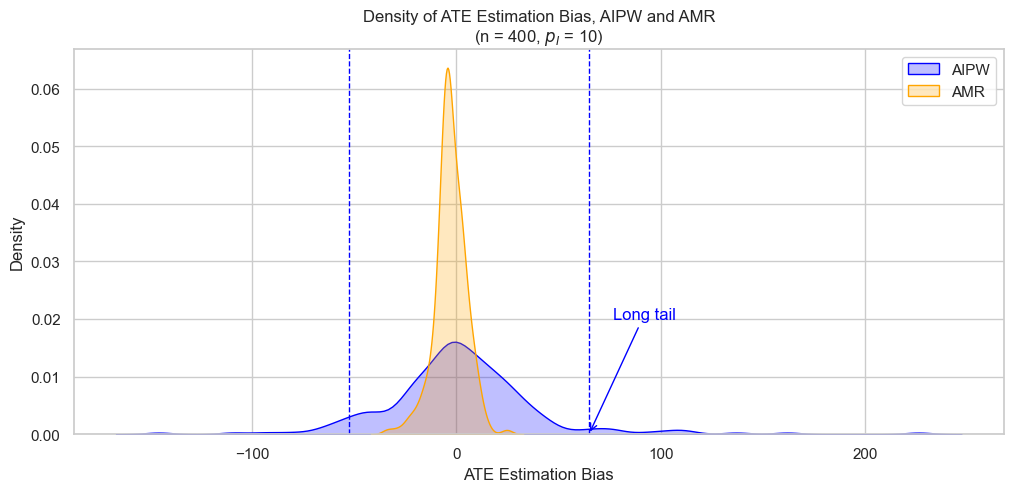

In [6]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Settings: use n=400 and p_I=10
n = 400
p = 10

# Construct the filename and load the ATE results.
ate_filename = f"results/CollaborativeLearning/causl_non_linear/ate_n{n}_s{p}.joblib"
try:
    ate_results = joblib.load(ate_filename)
except Exception as e:
    print(f"Could not load {ate_filename}: {e}")
    exit()

# Extract the ATE estimations for AIPW and AMR.
ate_aipw = np.array(ate_results['ate_aipw'])-np.array(ate_results['true_ate'])
ate_amr  = np.array(ate_results['ate_amr'])-np.array(ate_results['true_ate'])

# Set up the plot.
sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

# Plot density (kernel density estimate) for both methods.
# For AIPW, we use a lower bw_adjust to show a sharper, more concentrated peak.
sns.kdeplot(ate_aipw, shade=True, color='blue', label='AIPW', bw_adjust=0.5)
sns.kdeplot(ate_amr, shade=True, color='orange', label='AMR', bw_adjust=1)

# For AIPW, compute percentiles to locate the tail.
aipw_95 = np.percentile(ate_aipw, 95)
aipw_5  = np.percentile(ate_aipw, 5)

# Draw vertical dashed lines at the 5th and 95th percentiles of AIPW.
plt.axvline(aipw_5, color='blue', linestyle='--', lw=1)
plt.axvline(aipw_95, color='blue', linestyle='--', lw=1)

# Annotate the long tail for AIPW.
plt.annotate("Long tail", 
             xy=(aipw_95, 0), 
             xytext=(aipw_95 + 0.1*(aipw_95 - aipw_5), 0.02), 
             arrowprops=dict(arrowstyle="->", color='blue'),
             color='blue')

# Set labels and title.
plt.xlabel("ATE Estimation Bias")
plt.ylabel("Density")
plt.title("Density of ATE Estimation Bias, AIPW and AMR\n(n = 400, $p_I$ = 10)")
plt.legend()

plt.show()


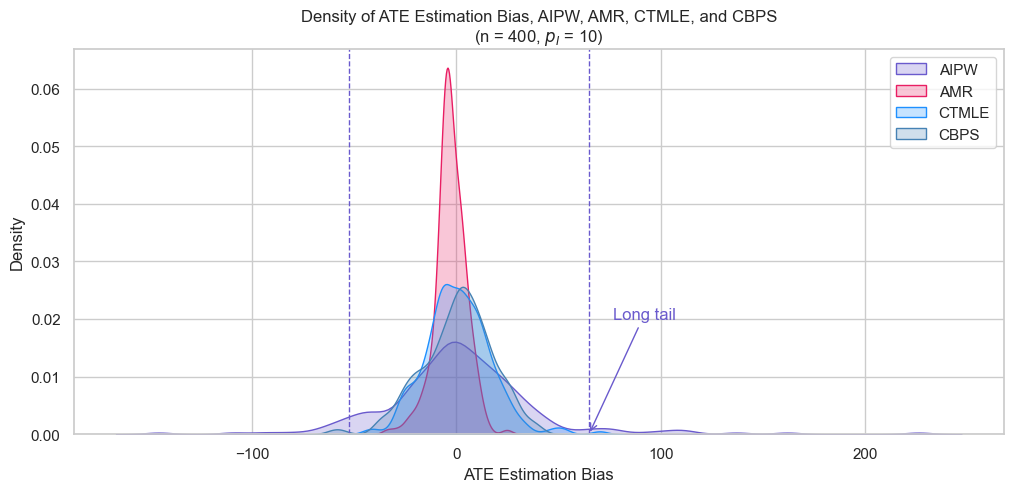

In [17]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Settings: use n=400 and p_I=10
n = 400
p = 10

# Construct the filename and load the ATE results.
ate_filename = f"results/CollaborativeLearning/causl_non_linear/ate_n{n}_s{p}.joblib"
try:
    ate_results = joblib.load(ate_filename)
except Exception as e:
    print(f"Could not load {ate_filename}: {e}")
    exit()

# Extract the ATE estimation biases.
ate_aipw  = np.array(ate_results['ate_aipw']) - np.array(ate_results['true_ate'])
ate_amr   = np.array(ate_results['ate_amr']) - np.array(ate_results['true_ate'])
ate_ctmle = np.array(ate_results['ate_ctmle']) - np.array(ate_results['true_ate'])
ate_cbps  = np.array(ate_results['ate_cbps']) - np.array(ate_results['true_ate'])

# Define improved colors
global_colors = {
    'ate_ctmle': "#1E90FF",  # Dodger Blue (bright, noticeable)
    'ate_cbps':  "#4682B4",  # Steel Blue (darker, neutral)
    'ate_aipw':  "#6A5ACD",  # Slate Blue (purple hue, distinct)
    'ate_mr':    "#C4B370",  # Mustard (unchanged)
    'ate_amr':   "#E91E63",  # Hot Pink (unchanged)
}

# Set up the plot.
sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

# Plot density (kernel density estimate) for each method.
sns.kdeplot(ate_aipw, shade=True, color=global_colors['ate_aipw'], label='AIPW', bw_adjust=0.5)
sns.kdeplot(ate_amr, shade=True, color=global_colors['ate_amr'], label='AMR', bw_adjust=1)
sns.kdeplot(ate_ctmle, shade=True, color=global_colors['ate_ctmle'], label='CTMLE', bw_adjust=0.7)
sns.kdeplot(ate_cbps, shade=True, color=global_colors['ate_cbps'], label='CBPS', bw_adjust=0.7)

# For AIPW, compute percentiles to locate the tail.
aipw_95 = np.percentile(ate_aipw, 95)
aipw_5  = np.percentile(ate_aipw, 5)

# Draw vertical dashed lines at the 5th and 95th percentiles of AIPW.
plt.axvline(aipw_5, color=global_colors['ate_aipw'], linestyle='--', lw=1)
plt.axvline(aipw_95, color=global_colors['ate_aipw'], linestyle='--', lw=1)

# Annotate the long tail for AIPW.
plt.annotate("Long tail", 
             xy=(aipw_95, 0), 
             xytext=(aipw_95 + 0.1*(aipw_95 - aipw_5), 0.02), 
             arrowprops=dict(arrowstyle="->", color=global_colors['ate_aipw']),
             color=global_colors['ate_aipw'])

# Set labels and title.
plt.xlabel("ATE Estimation Bias")
plt.ylabel("Density")
plt.title("Density of ATE Estimation Bias, AIPW, AMR, CTMLE, and CBPS\n(n = 400, $p_I$ = 10)")
plt.legend()

plt.show()


## Synthetic v1

In [3]:
ate_results, std_results = collaborative_trial(num_trials = 50, n=800, p=8, p_instr=3, ate=2, data_type='synthetic', gamma=10, strength_instr= 2, ps_model='original', or_model = 'original', random_seed=42, cross_fit=True, n_folds = 5)

ate_output_file = "results/CollaborativeLearning/synthetic_v1/ate_n800_s3.joblib"
std_output_file = "results/CollaborativeLearning/synthetic_v1/ate_n800_s3.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

100%|██████████| 50/50 [14:32<00:00, 17.45s/it]

Results saved to results/CollaborativeLearning/synthetic_v1/ate_n800_s3.joblib
Results saved to results/CollaborativeLearning/synthetic_v1/ate_n800_s3.joblib


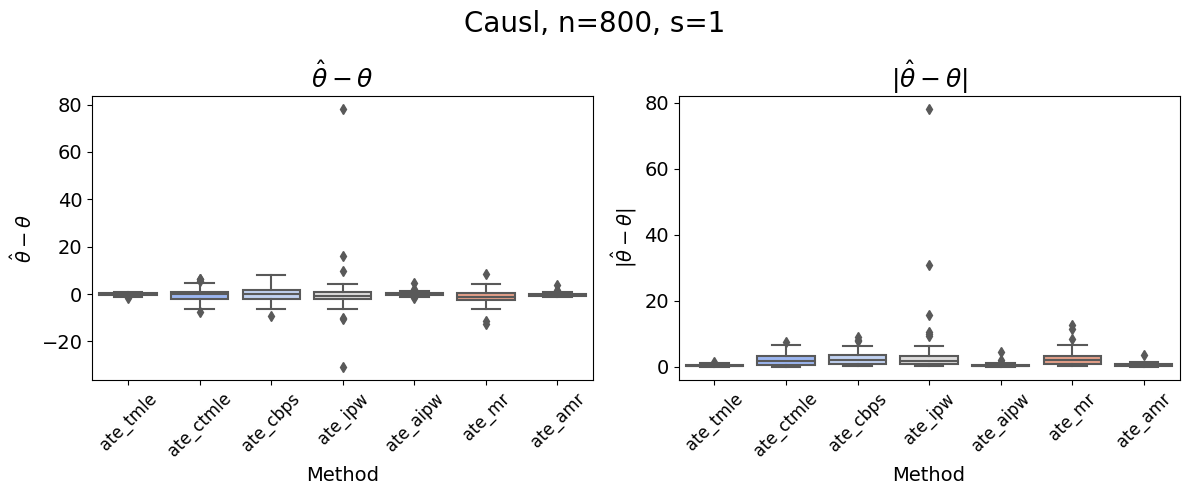

      Method  Mean_Diff  Mean_Abs_Diff       RMSE
0   ate_tmle  -0.048756       0.390202   0.500517
1  ate_ctmle  -0.151450       2.182009   2.905420
2   ate_cbps  -0.109960       2.600123   3.383102
3    ate_ipw   0.444219       4.812565  12.537229
4   ate_aipw   0.075420       0.510230   0.867459
5     ate_mr  -1.522937       2.681880   3.774522
6    ate_amr  -0.312317       0.610717   0.835148


In [4]:
# ate_results = load("results/sparsity/Dcal/ate_n400_p600_s30.joblib")
import matplotlib.pyplot as plt
import seaborn as sns


# Extract keys and true ATE
methods = [ 'ate_tmle', 'ate_ctmle', 'ate_cbps',  'ate_ipw','ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$|\hat{\theta}-\theta|$',
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(12, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Causl, n=800, s=1', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []
for method in methods:
    estimates = np.array(ate_results[method])
    mean_diff = np.mean(estimates - true_ate)
    mean_abs_diff = np.mean(np.abs(estimates - true_ate))
    rmse = np.sqrt(np.mean((estimates - true_ate)**2))
    summary_stats.append({'Method': method, 'Mean_Diff': mean_diff, 'Mean_Abs_Diff': mean_abs_diff, 'RMSE': rmse})

summary_df = pd.DataFrame(summary_stats)
print(summary_df)



In [5]:
ate_results, std_results = collaborative_trial(num_trials = 50, n=800, p=14, p_instr=9, ate=2, data_type='synthetic', gamma=10, strength_instr= 2, ps_model='original', or_model = 'original', random_seed=42, cross_fit=True, n_folds = 5)

ate_output_file = "results/CollaborativeLearning/synthetic_v1/ate_n800_s9.joblib"
std_output_file = "results/CollaborativeLearning/synthetic_v1/ate_n800_s9.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

100%|██████████| 50/50 [16:22<00:00, 19.65s/it]

Results saved to results/CollaborativeLearning/synthetic_v1/ate_n800_s9.joblib
Results saved to results/CollaborativeLearning/synthetic_v1/ate_n800_s9.joblib


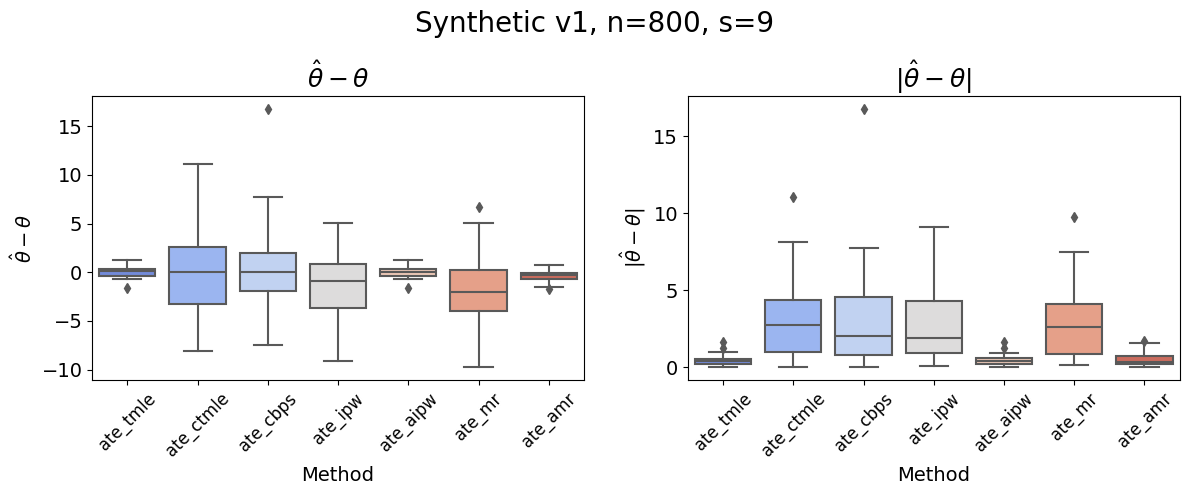

      Method  Mean_Diff  Mean_Abs_Diff      RMSE
0   ate_tmle   0.004574       0.406030  0.501633
1  ate_ctmle   0.105537       2.872918  3.692090
2   ate_cbps   0.112647       2.884141  4.118902
3    ate_ipw  -1.256156       2.590031  3.285986
4   ate_aipw   0.000025       0.406014  0.506888
5     ate_mr  -1.783842       2.850191  3.557015
6    ate_amr  -0.376787       0.490296  0.626136


In [6]:
# ate_results = load("results/sparsity/Dcal/ate_n400_p600_s30.joblib")
import matplotlib.pyplot as plt
import seaborn as sns


# Extract keys and true ATE
methods = [ 'ate_tmle', 'ate_ctmle', 'ate_cbps',  'ate_ipw','ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$|\hat{\theta}-\theta|$',
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(12, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Synthetic v1, n=800, s=9', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []
for method in methods:
    estimates = np.array(ate_results[method])
    mean_diff = np.mean(estimates - true_ate)
    mean_abs_diff = np.mean(np.abs(estimates - true_ate))
    rmse = np.sqrt(np.mean((estimates - true_ate)**2))
    summary_stats.append({'Method': method, 'Mean_Diff': mean_diff, 'Mean_Abs_Diff': mean_abs_diff, 'RMSE': rmse})

summary_df = pd.DataFrame(summary_stats)
print(summary_df)



In [ ]:
ate_results, std_results = collaborative_trial(num_trials = 50, n=800, p=14, p_instr=9, ate=2, data_type='synthetic', gamma=10, strength_instr= 2, ps_model='original', or_model = 'original', random_seed=42, cross_fit=True, n_folds = 5)

ate_output_file = "results/CollaborativeLearning/synthetic_v1/ate_n800_s9.joblib"
std_output_file = "results/CollaborativeLearning/synthetic_v1/ate_n800_s9.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

## Causl

In [3]:
ate_results, std_results = collaborative_trial(num_trials = 20, n=800, p=6, p_instr=1, ate=2, data_type='causl', strength_instr= 1, ps_model='lr', or_model = 'original', random_seed=42, cross_fit=True, n_folds = 3)

ate_output_file = "results/CollaborativeLearning/causl/ate_n800_s1.joblib"
std_output_file = "results/CollaborativeLearning/causl/std_n800_s1.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

100%|██████████| 20/20 [05:59<00:00, 17.98s/it]

Results saved to results/CollaborativeLearning/causl/ate_n800_s1.joblib
Results saved to results/CollaborativeLearning/causl/std_n800_s1.joblib


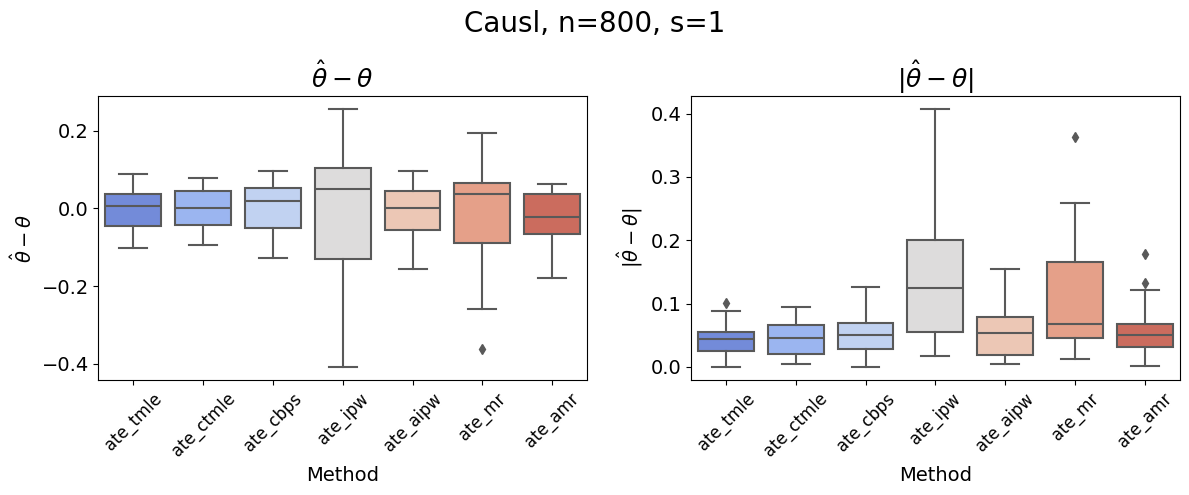

      Method  Mean_Diff  Mean_Abs_Diff      RMSE
0   ate_tmle   0.000459       0.043981  0.050969
1  ate_ctmle  -0.003233       0.044426  0.051510
2   ate_cbps   0.000698       0.052050  0.061120
3    ate_ipw  -0.003509       0.142864  0.173810
4   ate_aipw  -0.009721       0.057727  0.072913
5     ate_mr  -0.014356       0.113370  0.144057
6    ate_amr  -0.027354       0.059278  0.074089


In [5]:
# ate_results = load("results/sparsity/Dcal/ate_n400_p600_s30.joblib")
import matplotlib.pyplot as plt
import seaborn as sns


# Extract keys and true ATE
methods = [ 'ate_tmle', 'ate_ctmle', 'ate_cbps',  'ate_ipw','ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$|\hat{\theta}-\theta|$',
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(12, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Causl, n=800, s=1', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []
for method in methods:
    estimates = np.array(ate_results[method])
    mean_diff = np.mean(estimates - true_ate)
    mean_abs_diff = np.mean(np.abs(estimates - true_ate))
    rmse = np.sqrt(np.mean((estimates - true_ate)**2))
    summary_stats.append({'Method': method, 'Mean_Diff': mean_diff, 'Mean_Abs_Diff': mean_abs_diff, 'RMSE': rmse})

summary_df = pd.DataFrame(summary_stats)
print(summary_df)



In [6]:
ate_results, std_results = collaborative_trial(num_trials = 20, n=800, p=10, p_instr=5, ate=2, data_type='causl', strength_instr= 1, ps_model='lr', or_model = 'original', random_seed=42, cross_fit=True, n_folds = 3)

ate_output_file = "results/CollaborativeLearning/causl/ate_n800_s5.joblib"
std_output_file = "results/CollaborativeLearning/causl/std_n800_s5.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

100%|██████████| 20/20 [05:33<00:00, 16.68s/it]

Results saved to results/CollaborativeLearning/causl/ate_n800_s5.joblib
Results saved to results/CollaborativeLearning/causl/std_n800_s5.joblib


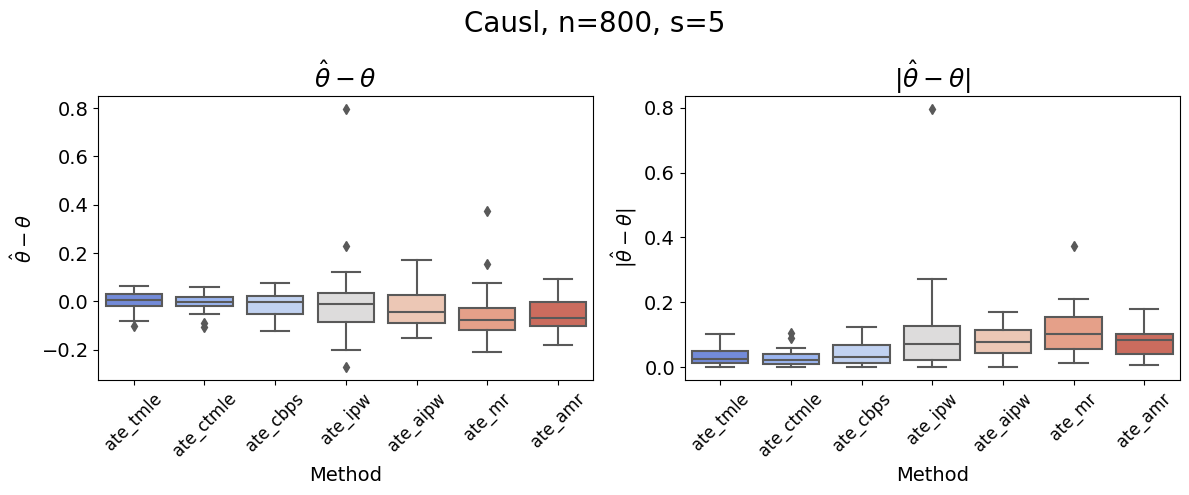

      Method  Mean_Diff  Mean_Abs_Diff      RMSE
0   ate_tmle   0.000343       0.032260  0.041900
1  ate_ctmle  -0.006076       0.028543  0.040058
2   ate_cbps  -0.013155       0.043511  0.056645
3    ate_ipw   0.017054       0.120151  0.210389
4   ate_aipw  -0.032987       0.079014  0.091987
5     ate_mr  -0.049409       0.111511  0.137596
6    ate_amr  -0.053937       0.075798  0.088323


In [7]:
# ate_results = load("results/sparsity/Dcal/ate_n400_p600_s30.joblib")
import matplotlib.pyplot as plt
import seaborn as sns


# Extract keys and true ATE
methods = [ 'ate_tmle', 'ate_ctmle', 'ate_cbps',  'ate_ipw','ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$|\hat{\theta}-\theta|$',
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(12, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Causl, n=800, s=5', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []
for method in methods:
    estimates = np.array(ate_results[method])
    mean_diff = np.mean(estimates - true_ate)
    mean_abs_diff = np.mean(np.abs(estimates - true_ate))
    rmse = np.sqrt(np.mean((estimates - true_ate)**2))
    summary_stats.append({'Method': method, 'Mean_Diff': mean_diff, 'Mean_Abs_Diff': mean_abs_diff, 'RMSE': rmse})

summary_df = pd.DataFrame(summary_stats)
print(summary_df)



In [8]:
ate_results, std_results = collaborative_trial(num_trials = 20, n=800, p=20, p_instr=15, ate=2, data_type='causl', strength_instr= 1, ps_model='lr', or_model = 'original', random_seed=42, cross_fit=True, n_folds = 3)

ate_output_file = "results/CollaborativeLearning/causl/ate_n800_s15.joblib"
std_output_file = "results/CollaborativeLearning/causl/std_n800_s15.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

100%|██████████| 20/20 [05:25<00:00, 16.25s/it]

Results saved to results/CollaborativeLearning/causl/ate_n800_s15.joblib
Results saved to results/CollaborativeLearning/causl/std_n800_s15.joblib


In [10]:
ate_results, std_results = collaborative_trial(num_trials = 20, n=800, p=20, p_instr=25, ate=2, data_type='causl', strength_instr= 1, ps_model='lr', or_model = 'original', random_seed=42, cross_fit=True, n_folds = 5)

ate_output_file = "results/CollaborativeLearning/causl/ate_n800_s25.joblib"
std_output_file = "results/CollaborativeLearning/causl/std_n800_s25.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

100%|██████████| 20/20 [09:14<00:00, 27.70s/it]

Results saved to results/CollaborativeLearning/causl/ate_n800_s25.joblib
Results saved to results/CollaborativeLearning/causl/std_n800_s25.joblib


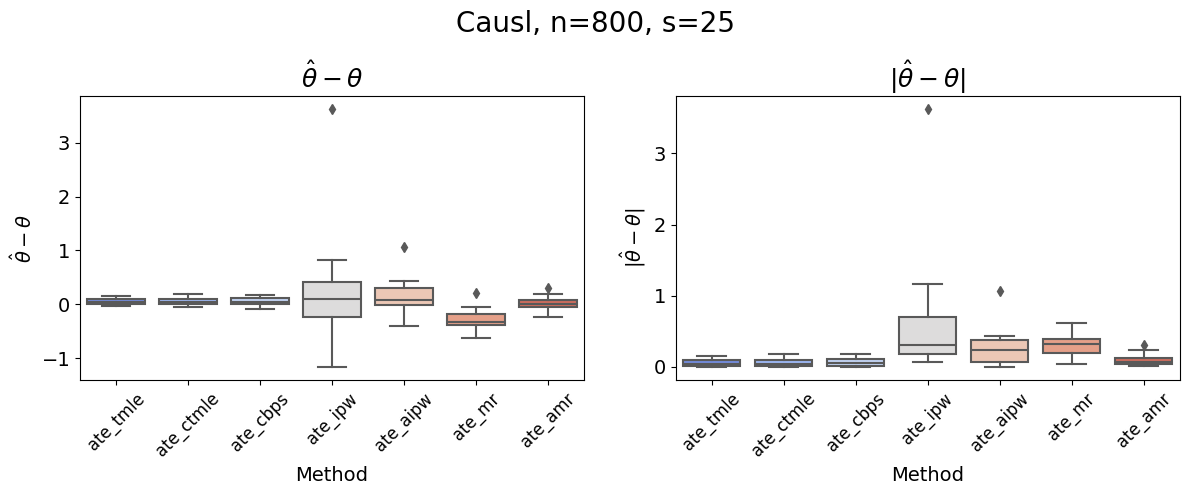

      Method  Mean_Diff  Mean_Abs_Diff      RMSE
0   ate_tmle   0.050360       0.055662  0.070993
1  ate_ctmle   0.054749       0.061212  0.080895
2   ate_cbps   0.053935       0.072459  0.094523
3    ate_ipw   0.219906       0.556782  0.942389
4   ate_aipw   0.153133       0.244692  0.342580
5     ate_mr  -0.292527       0.313158  0.344165
6    ate_amr   0.013785       0.093748  0.122315


In [11]:
# ate_results = load("results/sparsity/Dcal/ate_n400_p600_s30.joblib")
import matplotlib.pyplot as plt
import seaborn as sns


# Extract keys and true ATE
methods = [ 'ate_tmle', 'ate_ctmle', 'ate_cbps',  'ate_ipw','ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$|\hat{\theta}-\theta|$',
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(12, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Causl, n=800, s=25', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []
for method in methods:
    estimates = np.array(ate_results[method])
    mean_diff = np.mean(estimates - true_ate)
    mean_abs_diff = np.mean(np.abs(estimates - true_ate))
    rmse = np.sqrt(np.mean((estimates - true_ate)**2))
    summary_stats.append({'Method': method, 'Mean_Diff': mean_diff, 'Mean_Abs_Diff': mean_abs_diff, 'RMSE': rmse})

summary_df = pd.DataFrame(summary_stats)
print(summary_df)



In [12]:
estimates=ate_results['ate_tmle']
stds=np.array(std_results['std_tmle'])
lower_bounds = estimates - 1.96 * stds
upper_bounds = estimates + 1.96 * stds
print(np.mean(2*1.96*stds))
# Check if true_ate falls within the interval for all cases
coverage = np.mean((lower_bounds < true_ate) & (true_ate < upper_bounds))
coverage

0.08645047334775939


0.55

In [13]:
estimates=ate_results['ate_amr']
stds=np.array(std_results['std_amr'])
lower_bounds = estimates - 1.96 * stds
upper_bounds = estimates + 1.96 * stds
print(np.mean(2*1.96*stds))
# Check if true_ate falls within the interval for all cases
coverage = np.mean((lower_bounds < true_ate) & (true_ate < upper_bounds))
coverage

1.0074384333961262


1.0

In [14]:
estimates=ate_results['ate_aipw']
stds=np.array(std_results['std_aipw'])
lower_bounds = estimates - 1.96 * stds
upper_bounds = estimates + 1.96 * stds
print(np.mean(2*1.96*stds))
# Check if true_ate falls within the interval for all cases
coverage = np.mean((lower_bounds < true_ate) & (true_ate < upper_bounds))
coverage

1.0070241977714423


0.95

In [4]:
ate_results, std_results = collaborative_trial(num_trials = 20, n=800, p=90, p_instr=65, ate=2, data_type='causl', strength_instr= 1, ps_model='lr', or_model = 'original', random_seed=42, cross_fit=True, n_folds = 5)

ate_output_file = "results/CollaborativeLearning/causl/ate_n800_s65.joblib"
std_output_file = "results/CollaborativeLearning/causl/std_n800_s65.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

100%|██████████| 20/20 [36:06<00:00, 108.31s/it]

Results saved to results/CollaborativeLearning/causl/ate_n800_s65.joblib
Results saved to results/CollaborativeLearning/causl/std_n800_s65.joblib


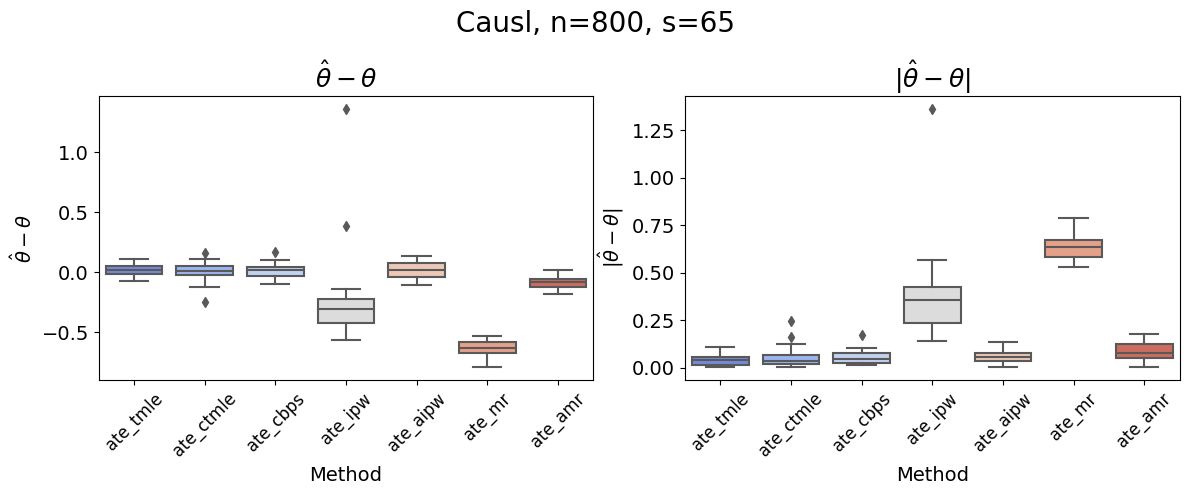

      Method  Mean_Diff  Mean_Abs_Diff      RMSE
0   ate_tmle   0.019629       0.042764  0.051330
1  ate_ctmle   0.006902       0.059097  0.083755
2   ate_cbps   0.010562       0.056061  0.068359
3    ate_ipw  -0.214972       0.389577  0.462401
4   ate_aipw   0.018856       0.060830  0.071198
5     ate_mr  -0.633444       0.633444  0.636420
6    ate_amr  -0.083597       0.086272  0.098072


In [5]:
# ate_results = load("results/sparsity/Dcal/ate_n400_p600_s30.joblib")
import matplotlib.pyplot as plt
import seaborn as sns


# Extract keys and true ATE
methods = [ 'ate_tmle', 'ate_ctmle', 'ate_cbps',  'ate_ipw','ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$|\hat{\theta}-\theta|$',
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(12, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Causl, n=800, s=65', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []
for method in methods:
    estimates = np.array(ate_results[method])
    mean_diff = np.mean(estimates - true_ate)
    mean_abs_diff = np.mean(np.abs(estimates - true_ate))
    rmse = np.sqrt(np.mean((estimates - true_ate)**2))
    summary_stats.append({'Method': method, 'Mean_Diff': mean_diff, 'Mean_Abs_Diff': mean_abs_diff, 'RMSE': rmse})

summary_df = pd.DataFrame(summary_stats)
print(summary_df)



## Synthetic v2

In [7]:
ate_results, std_results = collaborative_trial(num_trials = 50, n=600, p=50, p_instr=40,  data_type='synthetic_v2', 
                            ps_model='original', or_model = 'original', random_seed=42, 
                            cross_fit=True, n_folds = 5)

ate_output_file = "results/CollaborativeLearning/synthetic_v2/ate_n600_p50_s40.joblib"
std_output_file = "results/CollaborativeLearning/synthetic_v2/std_n600_p50_s40.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

100%|██████████| 50/50 [34:07<00:00, 40.94s/it]

Results saved to results/CollaborativeLearning/synthetic_v2/ate_n600_p50_s40.joblib
Results saved to results/CollaborativeLearning/synthetic_v2/std_n600_p50_s40.joblib


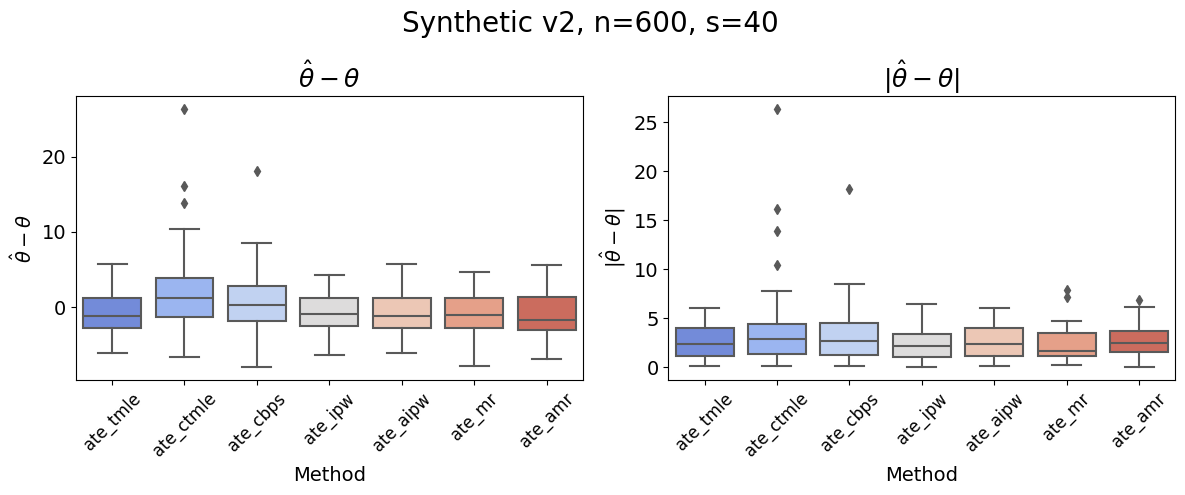

      Method  Mean_Diff  Mean_Abs_Diff      RMSE
0   ate_tmle  -0.598119       2.630247  3.163612
1  ate_ctmle   2.049755       3.888168  5.964537
2   ate_cbps   0.688550       3.366888  4.556314
3    ate_ipw  -0.839825       2.410267  2.948061
4   ate_aipw  -0.600277       2.633485  3.167126
5     ate_mr  -1.008711       2.240959  2.810747
6    ate_amr  -1.104143       2.756654  3.217474


In [9]:
# Extract keys and true ATE
methods = [ 'ate_tmle', 'ate_ctmle', 'ate_cbps',  'ate_ipw','ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$|\hat{\theta}-\theta|$',
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(12, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Synthetic v2, n=600, s=40', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []
for method in methods:
    estimates = np.array(ate_results[method])
    mean_diff = np.mean(estimates - true_ate)
    mean_abs_diff = np.mean(np.abs(estimates - true_ate))
    rmse = np.sqrt(np.mean((estimates - true_ate)**2))
    summary_stats.append({'Method': method, 'Mean_Diff': mean_diff, 'Mean_Abs_Diff': mean_abs_diff, 'RMSE': rmse})

summary_df = pd.DataFrame(summary_stats)
print(summary_df)



In [4]:
ate_results, std_results = collaborative_trial(num_trials = 50, n=800, p=50, p_instr=40,  data_type='synthetic_v2', ps_model='original', or_model = 'original', random_seed=42, cross_fit=True, n_folds = 5)

ate_output_file = "results/CollaborativeLearning/synthetic_v2/ate_n800_p50_s40.joblib"
std_output_file = "results/CollaborativeLearning/synthetic_v2/std_n800_p50_s40.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

100%|██████████| 50/50 [2:26:57<00:00, 176.34s/it]   

Results saved to results/CollaborativeLearning/synthetic_v2/ate_n800_p50_s40.joblib
Results saved to results/CollaborativeLearning/synthetic_v2/std_n800_p50_s40.joblib


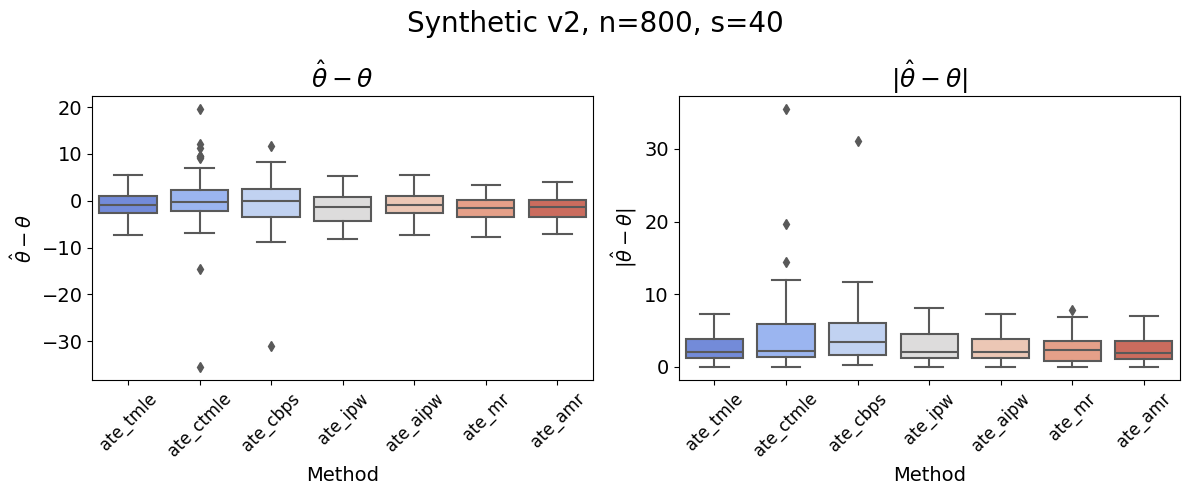

      Method  Mean_Diff  Mean_Abs_Diff      RMSE
0   ate_tmle  -1.094715       2.581359  3.269284
1  ate_ctmle  -0.021628       4.715719  7.640191
2   ate_cbps  -0.503130       4.362438  6.356831
3    ate_ipw  -1.474598       2.807009  3.465456
4   ate_aipw  -1.108584       2.564527  3.246755
5     ate_mr  -1.850400       2.484290  3.153134
6    ate_amr  -1.447751       2.394316  3.029461


In [5]:
# Extract keys and true ATE
methods = [ 'ate_tmle', 'ate_ctmle', 'ate_cbps',  'ate_ipw','ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$|\hat{\theta}-\theta|$',
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(12, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Synthetic v2, n=800, s=40', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []
for method in methods:
    estimates = np.array(ate_results[method])
    mean_diff = np.mean(estimates - true_ate)
    mean_abs_diff = np.mean(np.abs(estimates - true_ate))
    rmse = np.sqrt(np.mean((estimates - true_ate)**2))
    summary_stats.append({'Method': method, 'Mean_Diff': mean_diff, 'Mean_Abs_Diff': mean_abs_diff, 'RMSE': rmse})

summary_df = pd.DataFrame(summary_stats)
print(summary_df)



In [11]:
ate_results, std_results = collaborative_trial(num_trials = 20, n=800, p=100, p_instr=80,  data_type='synthetic_v2', ps_model='original', or_model = 'original', random_seed=42, cross_fit=True, n_folds = 5)

ate_output_file = "results/CollaborativeLearning/synthetic_v2/ate_n800_p100_s80.joblib"
std_output_file = "results/CollaborativeLearning/synthetic_v2/std_n800_p100_s80.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

100%|██████████| 20/20 [1:33:20<00:00, 280.02s/it]

Results saved to results/CollaborativeLearning/synthetic_v2/ate_n800_p100_s80.joblib
Results saved to results/CollaborativeLearning/synthetic_v2/std_n800_p100_s80.joblib


In [18]:
estimates=ate_results['ate_amr']
stds=np.array(std_results['std_amr'])
lower_bounds = estimates - 2.36 * stds
upper_bounds = estimates + 2.36 * stds

# Check if true_ate falls within the interval for all cases
print(np.mean(2*1.96*stds))
coverage = np.mean((lower_bounds < true_ate) & (true_ate < upper_bounds))
coverage


10.202863887267863


1.0

In [14]:
estimates=ate_results['ate_aipw']
stds=np.array(std_results['std_aipw'])
lower_bounds = estimates - 1.96 * stds
upper_bounds = estimates + 1.96 * stds
print(np.mean(2*1.96*stds))

# Check if true_ate falls within the interval for all cases
coverage = np.mean((lower_bounds < true_ate) & (true_ate < upper_bounds))
coverage

10.202531773317647


0.2

In [17]:
estimates=ate_results['ate_tmle']
stds=np.array(std_results['std_tmle'])
lower_bounds = estimates - 2.34 * stds
upper_bounds = estimates + 2.34 * stds
print(np.mean(2*1.96*stds))
# Check if true_ate falls within the interval for all cases
coverage = np.mean((lower_bounds < true_ate) & (true_ate < upper_bounds))
coverage

4.817620942708168


0.7

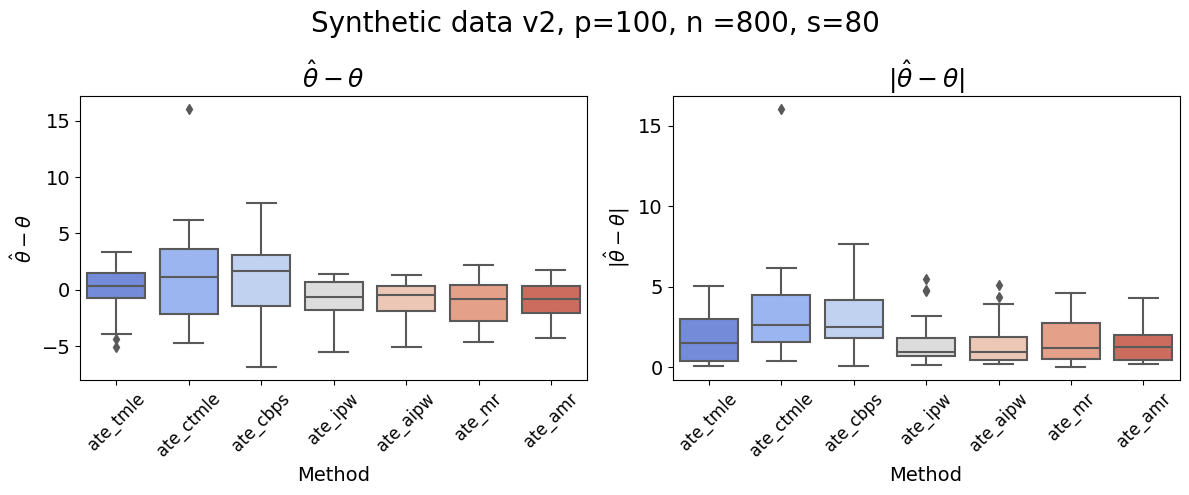

      Method  Mean_Diff  Mean_Abs_Diff      RMSE
0   ate_tmle  -0.095438       1.777272  2.347663
1  ate_ctmle   1.523745       3.446033  4.768707
2   ate_cbps   0.947754       2.982174  3.541180
3    ate_ipw  -1.084499       1.652032  2.285058
4   ate_aipw  -0.951559       1.480768  2.072922
5     ate_mr  -1.158914       1.666483  2.184832
6    ate_amr  -1.093177       1.583785  2.079168


In [16]:
# ate_results = load("results/sparsity/Dcal/ate_n400_p600_s30.joblib")
import matplotlib.pyplot as plt
import seaborn as sns


# Extract keys and true ATE
methods = [ 'ate_tmle', 'ate_ctmle', 'ate_cbps',  'ate_ipw','ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$|\hat{\theta}-\theta|$',
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(12, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Synthetic data v2, p=100, n =800, s=80', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []
for method in methods:
    estimates = np.array(ate_results[method])
    mean_diff = np.mean(estimates - true_ate)
    mean_abs_diff = np.mean(np.abs(estimates - true_ate))
    rmse = np.sqrt(np.mean((estimates - true_ate)**2))
    summary_stats.append({'Method': method, 'Mean_Diff': mean_diff, 'Mean_Abs_Diff': mean_abs_diff, 'RMSE': rmse})

summary_df = pd.DataFrame(summary_stats)
print(summary_df)



In [ ]:
# ate_results = load("results/sparsity/Dcal/ate_n400_p600_s30.joblib")
import matplotlib.pyplot as plt
import seaborn as sns


# Extract keys and true ATE
methods = [ 'ate_tmle', 'ate_ctmle', 'ate_cbps',  'ate_ipw','ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$|\hat{\theta}-\theta|$',
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(12, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Synthetic data v2, p=100, n =800, s=80', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []
for method in methods:
    estimates = np.array(ate_results[method])
    mean_diff = np.mean(estimates - true_ate)
    mean_abs_diff = np.mean(np.abs(estimates - true_ate))
    rmse = np.sqrt(np.mean((estimates - true_ate)**2))
    summary_stats.append({'Method': method, 'Mean_Diff': mean_diff, 'Mean_Abs_Diff': mean_abs_diff, 'RMSE': rmse})

summary_df = pd.DataFrame(summary_stats)
print(summary_df)

